# Data Mining on public tender data of public organizations and institutes from the Chile Compra platform

# TL;DR
This project analyzes the public tender data of public organizations and institutes in Chile. By using different data representations and data mining techniques, we were able to generate interesting insights and perform predictive tasks. One interesting insight is that unsold tenders can be re-published as a new tender with the same requested products. As such, traces of tenders can be created. We found that the majority of tenders that have been deserted due to lack of offers can be sold with high probability in the later re-published tender. However, deserted tenders are rarely re-published. This suggests that public organizations and institutes should consider re-publishing deserted tenders.

# 1. Introduction
Public organizations in Chile require different resources to maintain their daily operations. For example, the public clinics need bed sheets for patient beds. This means that there is a tremendous amount of demand which can be costly, inefficient and ineffective to meet if all the organizations have to find providers on their own.

The **Mercado Público** is a e-platform where 850 public organizations in Chile purchase different products and services in the form of public tenders and private providers bid for these tenders. This platform is managed by the organization la Dirección ChileCompra [1].

![figure_1](img/mercado.jpg)

Figure 1 shows the structure of Mercado Público. Consider the example where the police force of the San Joaquín have to purchase equipment for their operations. They would create a tender on the platform with specifications on the desired product. The specifications of a tender establish the requirement and conditions of the product and/or service, e.g., description, quantity, and deadlines. Once a tender is made public, providers can participate in the tender. From the list of offers, the police force would choose and accept the best offer as evaluated against the established criteria in the specification and would send the offer to the respective provider. The provider can then accept or reject the sale order.

Outside of Mercado Público, there are also other ways for purchase, e.g., Convenio Marco and private tenders. In this project, we only looked at the data of the public tenders.

According to [5], "Big Data" can be described by the volumn, variety, velocity, variability, and veracity. This platform generates more than 6000 transactions per day and has more than 100000 providers. These statistics suggest a high volumn and velocity of data exchange.

Different data mining techniques have been applied in the project, including clustering and classification techniques.

## Data description and initial exploration
### How we got the data?
1. We downloaded the list of tenders in 2016 from [ChileCompra Analiza](http://www.analiza.cl/web/Modulos/Reportes/ReporteLicitaciones.aspx)
2. Using the [API Mercado Publico](http://api.mercadopublico.cl/modules/api.aspx), we downloaded the data in JSON format.
3. We then cleaned the data and put them into CSV format for analysis.

In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/startup-01.py
# start up settings for ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import functools as fcts

plt.style.use('ggplot')
plt.rcParams['font.size'] = 20.0
plt.rcParams['axes.labelsize'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
plt.rcParams['legend.fontsize'] = 20.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000


In [2]:
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.ticker as mtick
matplotlib.style.use('ggplot')

### Analyzing the tenders in Nov 2016

In [3]:
base_dir = '.'
data_dir = os.path.join('.', 'data', 'dataNov2016')

In [4]:
tender_df = pd.read_csv(os.path.join(data_dir, 'tender.csv'))
tprod_df = pd.read_csv(os.path.join(data_dir, 'tenderProduct.csv'))

### Conversion of date data to datetime

In [5]:
tender_df['AdjudicacionFecha'].values[:1]

array(['2016-11-28T00:00:00'], dtype=object)

In [6]:
date_colnames = filter(lambda colname: 'Fecha' in colname, tender_df.columns)
for colname in date_colnames:
#    print('Parsing {}'.format(colname))
    tender_df[colname] = pd.to_datetime(tender_df[colname])

#### Make the desierta state shorter

In [7]:
def shorten_desierta(val):
    if 'Desierta' in val:
        return 'Desierta'
    else:
        return val
    
tender_df['Estado'] = tender_df['Estado'].apply(lambda val: shorten_desierta(val))

## Distribution of tenders per tender state

In [8]:
sold_tender_list = tender_df[(tender_df['Estado'] == 'Adjudicada')]
print('Number of tenders sold: {}/{}'.format(sold_tender_list.shape[0], tender_df.shape[0]))
print('Percentage of tenders sold: {}'.format(sold_tender_list.shape[0]/tender_df.shape[0]))

Number of tenders sold: 13430/17165
Percentage of tenders sold: 0.7824060588406642


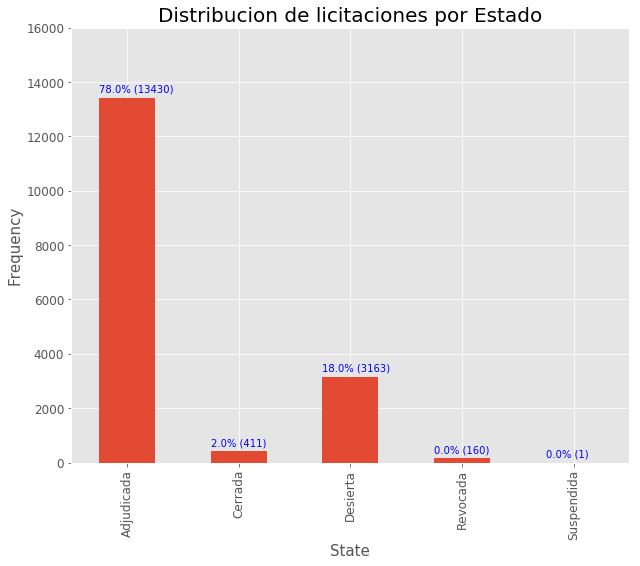

In [9]:
# rename deserted to shorter names
rename_func = lambda x: x if 'Desierta' not in x else 'Desierta'
renamed_tender_df = tender_df.copy()
renamed_tender_df['Estado'] = renamed_tender_df['Estado'].apply(rename_func)

tender_state_df = renamed_tender_df.groupby('Estado')['CodigoExterno'].count()
ax = tender_state_df.plot.bar(figsize=(10, 8));
_ = ax.set_ylabel('Frequency', fontsize=15);
_ = ax.set_xlabel('State', fontsize=15);
_ = ax.set_ylim([0, 16000]);
_ = ax.set_title('Distribucion de licitaciones por Estado', fontsize=20);
_ = ax.tick_params(labelsize=12);

# add value label
total_count = tender_state_df.sum()
computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / (10 ** dp) * 100
for i, v in enumerate(tender_state_df.tolist()):
    _ = ax.text(i - 0.25, v + 200, '{}% ({})'.format(computer_perc(v, total_count, 2), v), color='blue', fontsize=10);

plt.show()

As shown above, there are 5 possible states:
- Adjudicada: Sold
- Cerrada: Closed 
- Desierta: Deserted
- Revocada: Revoked
- Suspendida: Suspended

It seems that there were quite a lot of tenders being deserted but the majority is sold.

### What does the deserted state means? -> [o art. 3 ó 9 Ley 19.886](https://www.leychile.cl/Navegar?idNorma=213004&r=1)
#### Art 3 Ley 19.886
Artículo 3º.- Quedan excluidos de la aplicación de la presente ley:
1. Las contrataciones de personal de la Administración del Estado reguladas por estatutos especiales y los contratos a honorarios que se celebren con personas naturales para que presten servicios a los organismos públicos, cualquiera que sea la fuente legal en que se sustenten;
2. Los convenios que celebren entre sí los organismos públicos enumerados en el artículo 2º, inciso primero, del decreto ley Nº 1.263, de 1975, Ley Orgánica de Administración Financiera del Estado, y sus modificaciones;
3. Los contratos efectuados de acuerdo con el procedimiento específico de un organismo internacional, asociados a créditos o aportes que éste otorgue;
...

#### Art 9 Ley 19.886
Artículo 9º.- El órgano contratante declarará inadmisibles las ofertas cuando éstas no cumplieren los requisitos establecidos en las bases. Declarará desierta una licitación cuando no se presenten ofertas, o bien, cuando éstas no resulten convenientes a sus intereses.
En ambos casos la declaración deberá ser por resolución fundada.

Basically, the above laws state that a tender can be deserted if the products or service do not meet the specified requirement.

## Distribution of tenders per region

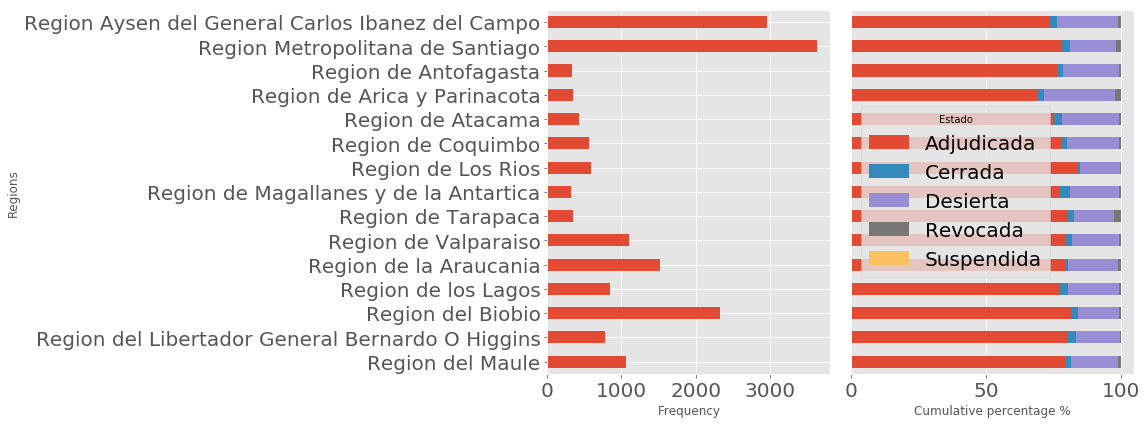

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)

# group by region
grouped_region = tender_df.groupby('CompradorRegionUnidad').size()
grouped_region.sort_index(inplace=True, ascending=False)
_ = grouped_region.plot(kind='barh', figsize=(16, 6), ax=axes[0])
_ = axes[0].set_xlabel('Frequency')
_ = axes[0].set_ylabel('Regions')

# distribution of tender states within regions
grouped_region_state = tender_df.groupby(['CompradorRegionUnidad', 'Estado']).size()
grouped_region_state = grouped_region_state.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
grouped_region_state.sort_index(inplace=True, ascending=False)
_ = grouped_region_state.plot(kind='barh', stacked=True, figsize=(16, 6), ax=axes[1])
_ = axes[1].set_yticks(ticks=[])
_ = axes[1].set_ylabel('')
_ = axes[1].set_xlabel('Cumulative percentage %')
plt.tight_layout()

## Distribution of tenders per tender duration

In [11]:
cols = ['CodigoExterno'] + list(filter(lambda colname: 'Fecha' in colname, tender_df.columns))
# only analyze sold tenders
ttime_df = tender_df.loc[(tender_df['Estado'] == 'Adjudicada'), cols]

ttime_df['time_duration_days'] = (ttime_df['FechasFechaCierre'] - ttime_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_df['time_sale_days'] = (ttime_df['FechasFechaAdjudicacion'] - ttime_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_df['time_decision_days'] = (ttime_df['FechasFechaEstimadaAdjudicacion'] - ttime_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_df['time_estimation_error_days'] = (ttime_df['FechasFechaEstimadaAdjudicacion'] - ttime_df['FechasFechaAdjudicacion']) / np.timedelta64(1, 'D')

### Make continuous categorical

In [12]:
min_time_duration = ttime_df['time_duration_days'].min()
max_time_duration = ttime_df['time_duration_days'].max()

min_time_sale = ttime_df['time_sale_days'].min()
max_time_sale = ttime_df['time_sale_days'].max()

min_time_decision = ttime_df['time_decision_days'].min()
max_time_decision = ttime_df['time_decision_days'].max()

min_time_estimation_error = ttime_df['time_estimation_error_days'].min()
max_time_estimation_error = ttime_df['time_estimation_error_days'].max()

print('Min time duration: {}\nMax time duration: {}'.format(min_time_duration, max_time_duration))
print('Min sale time: {}\nMax sale time: {}'.format(min_time_sale, max_time_sale))
print('Min decision time: {}\nMax decision time: {}'.format(min_time_decision, max_time_decision))
print('Min estimation error time: {}\nMax estimation error time: {}'.format(min_time_estimation_error, 
                                                                           max_time_estimation_error))
bin_sz = 10
bins_time_duration = [ind * bin_sz for ind in range(0, int(max_time_duration) // bin_sz + 1)]
bins_time_sale = [ind * bin_sz for ind in range(0, int(max_time_sale) // bin_sz + 1)]
bins_time_decision = [ind * bin_sz for ind in range(0, int(max_time_decision) // bin_sz + 1)]
bins_time_estimation = [ind * bin_sz for ind in range(0, int(max_time_estimation_error) // bin_sz + 1)]

ttime_df['time_duration_days_cat'] = pd.cut(ttime_df['time_duration_days'], bins=bins_time_duration)
ttime_df['time_sale_days_cat'] = pd.cut(ttime_df['time_sale_days'], bins=bins_time_sale)
ttime_df['time_decision_days_cat'] = pd.cut(ttime_df['time_decision_days'], bins=bins_time_decision)
ttime_df['time_estimation_error_days_cat'] = pd.cut(ttime_df['time_estimation_error_days'], bins=bins_time_estimation)

Min time duration: 0.0012789699074074075
Max time duration: 176.14305555555555
Min sale time: 0.004895520833333333
Max sale time: 285.2177521990741
Min decision time: 5.158496099537037
Max decision time: 752.2580340277777
Min estimation error time: -240.71942974537038
Max estimation error time: 682.053589201389


We created the features:
- tender time duration
- tender sale time 
- estimation error in tender sale time

and the features are in days.

### Distribution of tender duration (date_close - date_publication)

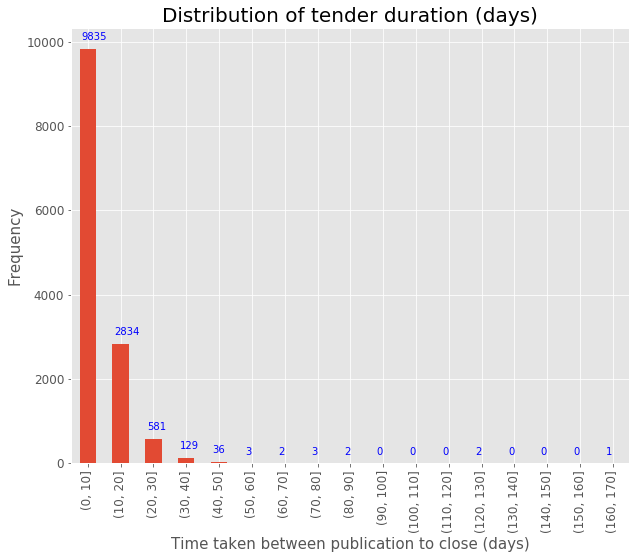

In [13]:
ttime_duration_df = ttime_df.groupby('time_duration_days_cat')['CodigoExterno'].count()
ax = ttime_duration_df.plot.bar(figsize=(10, 8));
_ = ax.set_xlabel('Time taken between publication to close (days)', fontsize=15);
_ = ax.set_ylabel('Frequency', fontsize=15);
_ = ax.set_title('Distribution of tender duration (days)', fontsize=20);
_ = ax.tick_params(labelsize=12)

for i, v in enumerate(ttime_duration_df.tolist()):
    _ = ax.text(i - 0.2, v + 200, str(v), color='blue', fontsize=10);

plt.show()

Number of tenders with duration < 50 days: 13415/13430 (0.99%)
Min duration time: 0.0012789699074074075
Max duration time: 48.95692461805555


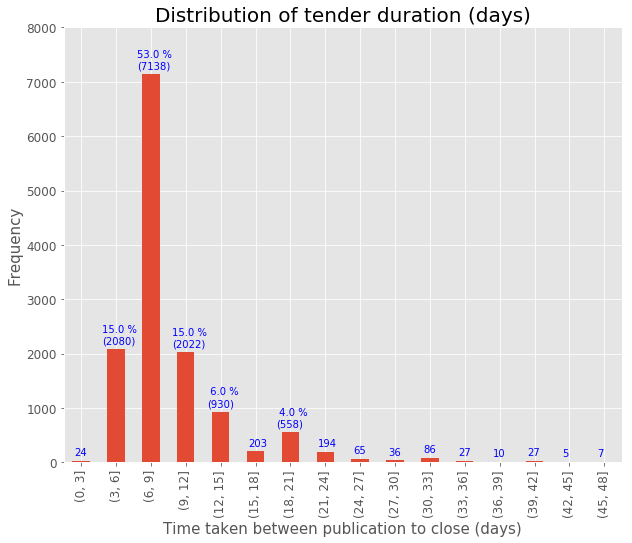

In [14]:
day_threshold = 50
ttime_df1 = ttime_df.loc[(ttime_df['time_duration_days'] < day_threshold),:]
nrow = ttime_df1.shape[0]
total = ttime_df.shape[0]
perc = int(nrow / total * 100) / 100
print('Number of tenders with duration < {} days: {}/{} ({}%)'.format(day_threshold,
                                                                     nrow, total, perc))
min_time_duration = ttime_df1['time_duration_days'].min()
max_time_duration = ttime_df1['time_duration_days'].max()
print('Min duration time: {}\nMax duration time: {}'.format(min_time_duration, max_time_duration))

bin_sz = 3
bins = [ind * bin_sz for ind in range(0, int(max_time_duration) // bin_sz + 1)]

ttime_df1['time_duration_days_cat'] = pd.cut(ttime_df1.loc[:,'time_duration_days'], bins=bins)

ttime_duration_df1 = ttime_df1.groupby('time_duration_days_cat')['CodigoExterno'].count()
ax = ttime_duration_df1.plot.bar(figsize=(10, 8))
_ = ax.set_ylim([0, 8000])
_ = ax.set_xlabel('Time taken between publication to close (days)', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of tender duration (days)', fontsize=20)
_ = ax.tick_params(labelsize=12)

computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / int(10 ** dp) * 100
for i, v in enumerate(ttime_duration_df1.tolist()):
    if v > 500:
        _ = ax.text(i - 0.4, v + 100, '{:^5}%\n({})'.format(computer_perc(v, nrow, 2), v), color='blue', fontsize=10)
    else:
        _ = ax.text(i - 0.2, v + 100, str(v), color='blue', fontsize=10)
plt.show()

If we look at the tenders with a duration less than 50 days we would already be analyzing 99% of the tenders so this is a pretty good cut. We can identify that the majority of the tenders have a duration of 7 to 9 days and there's very few that have a duration of more than 24 days. From this we can infer that the majority of the organizations want their product and/or services asap. It would also be interesting to analyze the drop at the 15 to 18 days bin.

### Distribution of sale time (sale date - published date)

Number of tenders with sale duration < 200 days: 13386/13430 (0.99%)
Min sale days: 0.004895520833333333
Max sale days: 199.70378224537038


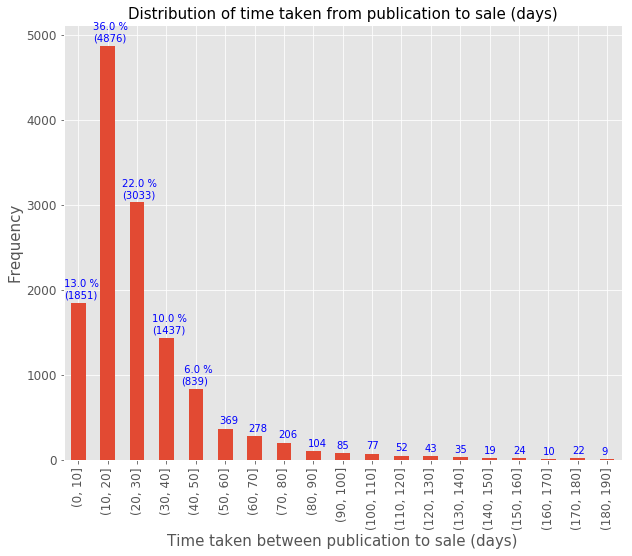

In [15]:
day_threshold = 200
ttime_sale_df1 = ttime_df.loc[(ttime_df['time_sale_days'] < day_threshold),:]
nrow = ttime_sale_df1.shape[0]
total = ttime_df.shape[0]
perc = int(nrow / total * 100) / 100
print('Number of tenders with sale duration < {} days: {}/{} ({}%)'.format(day_threshold, 
                                                                     nrow, total, perc))
min_sale_days = ttime_sale_df1['time_sale_days'].min()
max_sale_days = ttime_sale_df1['time_sale_days'].max()
print('Min sale days: {}\nMax sale days: {}'.format(min_sale_days, max_sale_days))

bin_sz = 10
bins = [ind * bin_sz for ind in range(0, int(max_sale_days) // bin_sz + 1)]
ttime_sale_df1['time_sale_days_cat'] = pd.cut(ttime_sale_df1.loc[:,'time_sale_days'], bins=bins)

ttime_sale_df1 = ttime_sale_df1.groupby('time_sale_days_cat')['CodigoExterno'].count()
ax = ttime_sale_df1.plot.bar(figsize=(10, 8))
_ = ax.set_xlabel('Time taken between publication to sale (days)', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of time taken from publication to sale (days)', fontsize=15)
_ = ax.tick_params(labelsize=12)

computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / int(10 ** dp) * int(100)
for i, v in enumerate(ttime_sale_df1.tolist()):
    perc = computer_perc(v, nrow, 2)
    if perc > 5:
        _ = ax.text(i - 0.5, v + 50, '{:^5}%\n({})'.format(perc, v), color='blue', fontsize=10)
    else:
        _ = ax.text(i - 0.2, v + 50, str(v), color='blue', fontsize=10)
plt.show()

## Analysis of the deserted tenders

### Types of deserted tenders

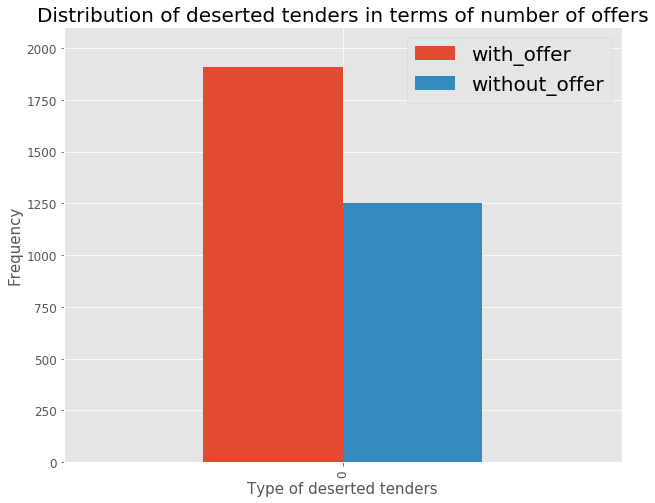

In [16]:
deserted_tenders = tender_df[(tender_df['Estado'].str.contains('Desierta'))]
# categorized by number of offers
deserted_tenders = deserted_tenders.groupby('AdjudicacionNumeroOferentes')['CodigoExterno'].count()
# separated into two bins, those with offer and those without
deserted_tenders_separated = pd.DataFrame({'without_offer': np.sum(deserted_tenders[(deserted_tenders.index == 0)]),
                                          'with_offer': np.sum(deserted_tenders[(deserted_tenders.index > 0)])},
                                         index=[0])
ax = deserted_tenders_separated.plot.bar(figsize=(10, 8))
_ = ax.set_ylim([0, 2100])
_ = ax.set_xlabel('Type of deserted tenders', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of deserted tenders in terms of number of offers', fontsize=20)
_ = ax.tick_params(labelsize=12)

plt.show()

In [17]:
without_offer_perc = deserted_tenders_separated['without_offer'] / deserted_tenders_separated.iloc[0, :].sum() * 100
with_offer_perc = deserted_tenders_separated['with_offer'] / deserted_tenders_separated.iloc[0, :].sum() * 100
print('{:.2f}% without offer\n{:.2f}% with offer'.format(without_offer_perc[0], with_offer_perc[0]))

39.61% without offer
60.39% with offer


### Distribution of sale time per deserted tenders

In [18]:
deserted_tenders = tender_df[(tender_df['Estado'].str.contains('Desierta'))&
                            (tender_df['AdjudicacionNumeroOferentes'] > 0)]
# compute different datetimes
cols = ['CodigoExterno'] + list(filter(lambda colname: 'Fecha' in colname, tender_df.columns))
# only analyze sold tenders
ttime_deserted_df = deserted_tenders.loc[:,cols]

cmp_diff_days = lambda row, col0, col1: (row[col0] - row[col1]) / np.timedelta64(1, 'D')

ttime_deserted_df['time_duration_days'] = (ttime_deserted_df['FechasFechaCierre'] - ttime_deserted_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_deserted_df['time_sale_days'] = (ttime_deserted_df['FechasFechaAdjudicacion'] - ttime_deserted_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_deserted_df['time_decision_days'] = (ttime_deserted_df['FechasFechaEstimadaAdjudicacion'] - ttime_deserted_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_deserted_df['time_estimation_error_days'] = (ttime_deserted_df['FechasFechaEstimadaAdjudicacion'] - ttime_deserted_df['FechasFechaAdjudicacion']) / np.timedelta64(1, 'D')

In [19]:
ttime_deserted_df['time_duration_days_cat'] = pd.cut(ttime_deserted_df['time_duration_days'], bins=10)
ttime_deserted_df['time_sale_days_cat'] = pd.cut(ttime_deserted_df['time_sale_days'], bins=10)
ttime_deserted_df['time_decision_days_cat'] = pd.cut(ttime_deserted_df['time_decision_days'], bins=10)
ttime_deserted_df['time_estimation_error_days_cat'] = pd.cut(ttime_deserted_df['time_estimation_error_days'], bins=10)

Number of deserted tenders with sale duration < 100 days: 1819/1910 (0.95%)
Min sale days: 6.0001062152777775
Max sale days: 99.92152164351852


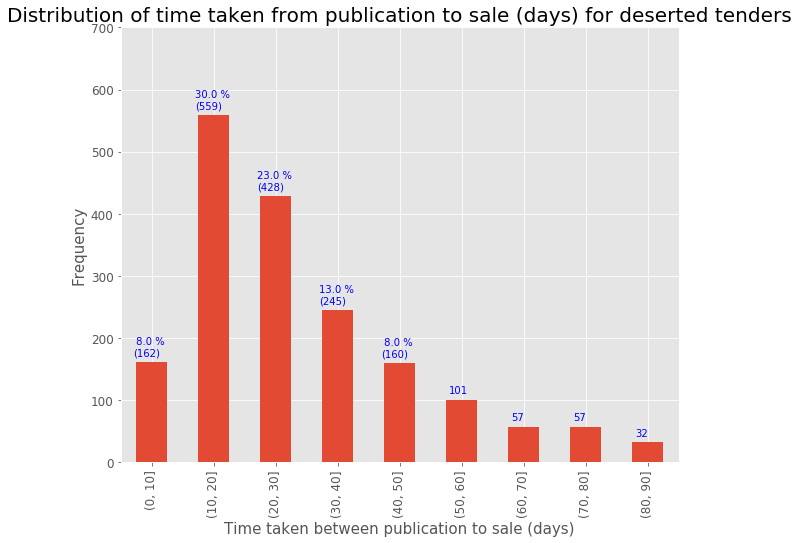

In [20]:
day_threshold = 100
ttime_deserted_sale_df1 = ttime_deserted_df.loc[(ttime_deserted_df['time_sale_days'] < day_threshold),:]
nrow = ttime_deserted_sale_df1.shape[0]
total = ttime_deserted_df.shape[0]
perc = int(nrow / total * 100) / 100
print('Number of deserted tenders with sale duration < {} days: {}/{} ({}%)'.format(day_threshold, 
                                                                     nrow, total, perc))

min_sale_days = ttime_deserted_sale_df1['time_sale_days'].min()
max_sale_days = ttime_deserted_sale_df1['time_sale_days'].max()
print('Min sale days: {}\nMax sale days: {}'.format(min_sale_days, max_sale_days))

bin_sz = 10
bins = [ind * bin_sz for ind in range(0, int(max_sale_days) // bin_sz + 1)]
ttime_deserted_sale_df1['time_sale_days_cat'] = pd.cut(ttime_deserted_sale_df1['time_sale_days'], bins=bins)

ttime_deserted_sale_df1 = ttime_deserted_sale_df1.groupby('time_sale_days_cat')['CodigoExterno'].count()
ax = ttime_deserted_sale_df1.plot.bar(figsize=(10, 8))
_ = ax.set_ylim([0, 700])
_ = ax.set_xlabel('Time taken between publication to sale (days)', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of time taken from publication to sale (days) for deserted tenders', fontsize=20)
_ = ax.tick_params(labelsize=12)

computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / int(10 ** dp) * int(100)
for i, v in enumerate(ttime_deserted_sale_df1.tolist()):
    perc = computer_perc(v, nrow, 2)
    if perc > 5:
        _ = ax.text(i - 0.3, v + 10, '{:^5.1f}%\n({})'.format(perc, v), color='blue', fontsize=10)
    else:
        _ = ax.text(i - 0.2, v + 10, str(v), color='blue', fontsize=10)
plt.show()

## Offers

### Distribution of tenders per number of offerers

Min num of offer: 0.0
Max num of offer: 69.0


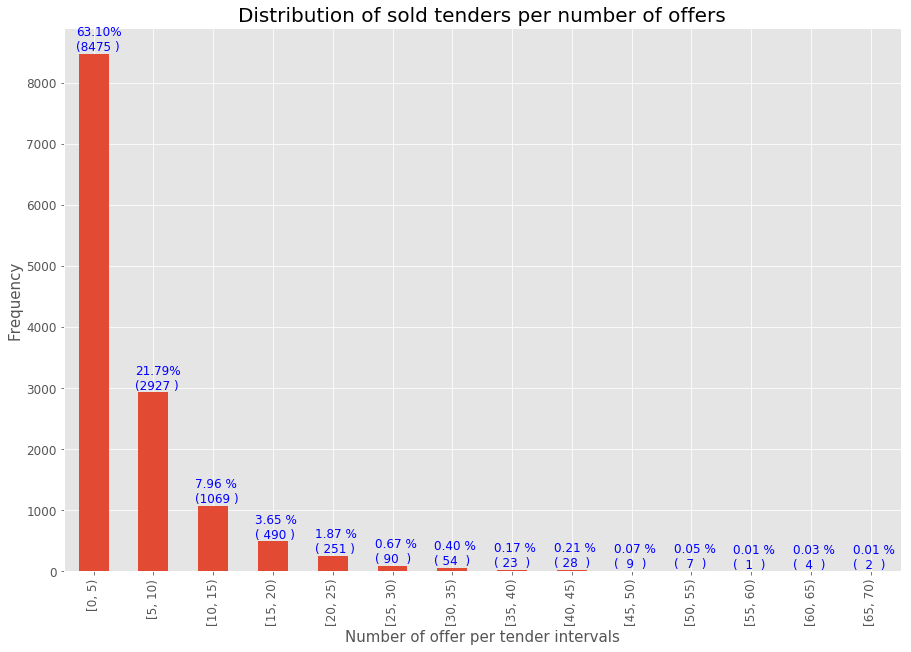

In [21]:
tender_df_modified = tender_df.loc[(tender_df['Estado'].str.contains('Adjudicada')), :]
offer_count_df = tender_df_modified.groupby('AdjudicacionNumeroOferentes')['CodigoExterno'].count().to_frame()

min_offer = offer_count_df.index.min()
max_offer = offer_count_df.index.max()
print('Min num of offer: {}\nMax num of offer: {}'.format(min_offer, max_offer))

interval_sz = 5
bins = [ind * interval_sz for ind in range(0, int(max_offer) // interval_sz + 2)]
offer_count_df['count_cat'] = pd.cut(offer_count_df.index.tolist(), bins=bins, include_lowest=True, right=False)

offer_count_cat = offer_count_df.groupby('count_cat')['CodigoExterno'].sum()

ax = offer_count_cat.plot.bar(figsize=(15, 10))
_ = ax.set_xlabel('Number of offer per tender intervals', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of sold tenders per number of offers', fontsize=20)
_ = ax.tick_params(labelsize=12)

total = offer_count_cat.sum()
cmp_perc = lambda x, total: x / total * 100
for i, v in enumerate(offer_count_cat.tolist()):
    if np.isnan(v):
        _ = ax.text(i - 0.3, 50, '{:^5.2f}%\n({:^5})'.format(cmp_perc(v, total), v), fontsize=12, color='blue')
    else:
        _ = ax.text(i - 0.3, v + 50, '{:^5.2f}%\n({:^5.0f})'.format(cmp_perc(v, total), v), fontsize=12, color='blue')

plt.show()


### Distribution of tenders per number of offers

Min num of offer: 0.0
Max num of offer: 42.0


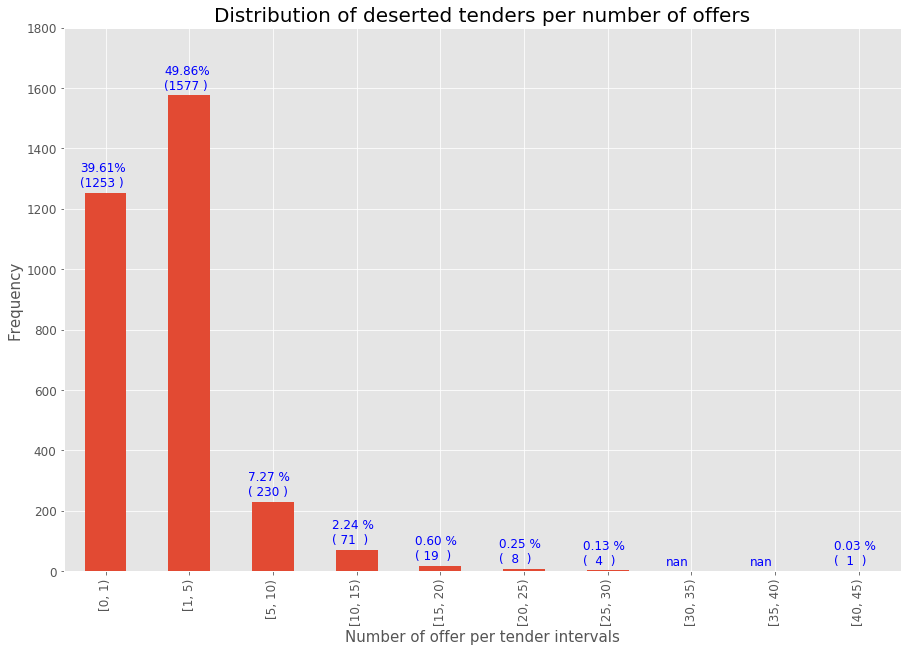

In [22]:
tender_df_modified = tender_df.loc[(tender_df['Estado'].str.contains('Desierta')), :]
offer_count_df = tender_df_modified.groupby('AdjudicacionNumeroOferentes')['CodigoExterno'].count().to_frame()

min_offer = offer_count_df.index.min()
max_offer = offer_count_df.index.max()
print('Min num of offer: {}\nMax num of offer: {}'.format(min_offer, max_offer))

interval_sz = 5
bins = [0, 1] + [ind * interval_sz for ind in range(1, int(max_offer) // interval_sz + 2)]
offer_count_df['count_cat'] = pd.cut(offer_count_df.index.tolist(), bins=bins, include_lowest=True, right=False)

offer_count_cat = offer_count_df.groupby('count_cat')['CodigoExterno'].sum()

ax = offer_count_cat.plot.bar(figsize=(15, 10))
_ = ax.set_ylim([0, 1800])
_ = ax.set_xlabel('Number of offer per tender intervals', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of deserted tenders per number of offers', fontsize=20)
_ = ax.tick_params(labelsize=12)

total = offer_count_cat.sum()
cmp_perc = lambda x, total: x / total * 100
for i, v in enumerate(offer_count_cat.tolist()):
    if np.isnan(v):
        _ = ax.text(i - 0.3, 20, str(v), fontsize=12, color='blue')
    else:
        _ = ax.text(i - 0.3, v + 20, '{:^5.2f}%\n({:^5.0f})'.format(cmp_perc(v, total), v), fontsize=12, color='blue')

plt.show()


### Distribution of tenders per bid amount

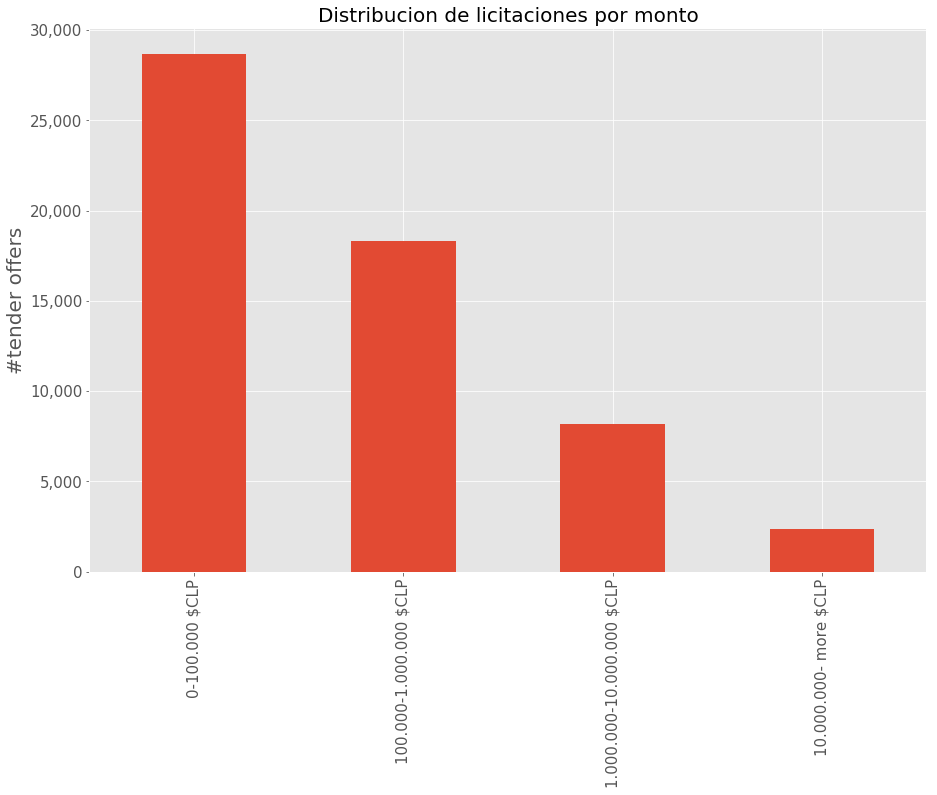

In [23]:
_ = %matplotlib inline 

tprod_df0 = tprod_df.copy(deep=True)

tprod_df0['tender_price'] = tprod_df0['AdjudicacionCantidad'] * tprod_df0['AdjudicacionMontoUnitario']

montos = tprod_df0['tender_price']

tramos_monto = pd.cut(montos, bins=[ 0, 100000, 1000000,10000000, 20000000000], include_lowest=False)

tramos_norm = tramos_monto.value_counts(sort=False)
graph_amounts = tramos_norm.plot.bar(figsize=(15,10))

_ = graph_amounts.set_ylabel('#tender offers', fontsize=20)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
_ = graph_amounts.yaxis.set_major_formatter(tick)
_ = graph_amounts.tick_params(labelsize=15)

_ = graph_amounts.set_xticklabels(['0-100.000 $CLP', '100.000-1.000.000 $CLP',
                                  '1.000.000-10.000.000 $CLP','10.000.000- more $CLP'], fontsize=15)

_ = graph_amounts.set_title('Distribucion de licitaciones por monto', fontsize=20)



## Research questions
### 1. How can we define a ***good*** tender?
A direct way to define a good tender would be one that is sold but one could also take into account other features, e.g., price and time and should consider the different perspectives, e.g., the perspective of the public organization and provider.

### 2. Does the region and product type affect the tender?
Even though all the tenders are on the same e-platform, it is reasonable to think that the tenders of different regions and product types would have different behavior.

## Some identified data problems
### 1) Not all items of a sold tender are sold

In [24]:
def has_nan(df):
    return df['AdjudicacionMontoUnitario'].isnull().any() and \
            df['AdjudicacionMontoUnitario'].unique().shape[0] > 1
    
to_choose = tprod_df.groupby('CodigoExterno', as_index=False).apply(has_nan)
mixed_tid_list = tender_df.loc[to_choose, 'CodigoExterno']
tid0 = mixed_tid_list.values[0]
tprod0 = tprod_df[(tprod_df['CodigoExterno']==tid0)]
tprod0_sold = tprod0.shape[0] - tprod0['AdjudicacionMontoUnitario'].isnull().sum()
print('{} (Adjudicada) tiene {} productos pero solamente {} son adjudicadas.'.format(tid0, tprod0.shape[0], tprod0_sold))

1020-45-LE16 (Adjudicada) tiene 6 productos pero solamente 3 son adjudicadas.


### 2) There can be duplicated sold products
Since a particular product (in row format) has many features, we only take a subset of its features. This means that we lose a little bit of the granularity required to distinguish between products. This results in possible duplicated sold products.

In [25]:
tprod_df[(tprod_df['CodigoExterno']=='2963-65-LR16')&(tprod_df['AdjudicacionNombreProveedor']=='NOVOFARMA SERVICE S A')]

,AdjudicacionCantidad,AdjudicacionMontoUnitario,AdjudicacionNombreProveedor,AdjudicacionRutProveedor,Cantidad,Categoria,CodigoCategoria,CodigoExterno,CodigoProducto,Correlativo,Descripcion,NombreProducto,UnidadMedida
38682,1.0,1.0,NOVOFARMA SERVICE S A,96.945.670-2,1.0,Equipamiento y suministros medicos / Articulos medicos para urgencias y atencion en terreno / Contenedores de almacenaje para servicios medicos de urgencia,42171900,2963-65-LR16,42171903,1,ADQUISICION DE MEDICAMENTOS INSUMOS MEDICOS Y DENTALES E INSTRUMENTAL,Cajas de medicamentos de servicios medicos de urgencia,Unidad
38702,1.0,1.0,NOVOFARMA SERVICE S A,96.945.670-2,1.0,Equipamiento y suministros medicos / Articulos medicos para urgencias y atencion en terreno / Contenedores de almacenaje para servicios medicos de urgencia,42171900,2963-65-LR16,42171903,1,ADQUISICION DE MEDICAMENTOS INSUMOS MEDICOS Y DENTALES E INSTRUMENTAL,Cajas de medicamentos de servicios medicos de urgencia,Unidad


## Experiments and prelim results

### Classification with the target is_adjudicadas

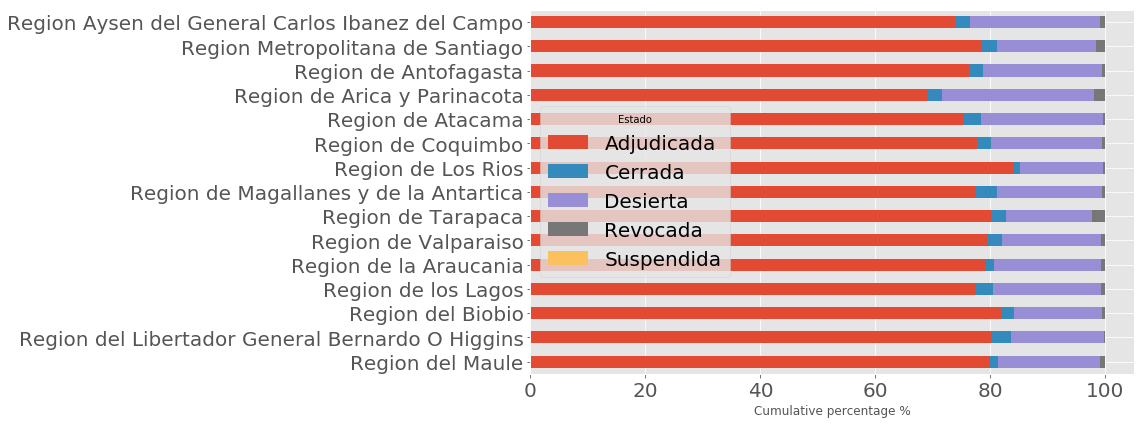

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# distribution of tender states within regions
grouped_region_state = tender_df.groupby(['CompradorRegionUnidad', 'Estado']).size()
grouped_region_state = grouped_region_state.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
grouped_region_state.sort_index(inplace=True, ascending=False)
_ = grouped_region_state.plot(kind='barh', stacked=True, figsize=(16, 6), ax=ax)
_ = ax.set_ylabel('')
_ = ax.set_xlabel('Cumulative percentage %')
plt.tight_layout()

### Creating the features

In [27]:
dataset = pd.merge(left=tprod_df, right=tender_df, on='CodigoExterno', how='left')

# remove all non Adjudicada nor Desierta tenders
dataset = dataset[(dataset['Estado'].isin(['Adjudicada', 'Desierta']))]

# create date features
dataset['time_duration_days'] = (dataset['FechasFechaCierre'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
dataset['time_est_decision_days'] = (dataset['FechasFechaEstimadaAdjudicacion'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')

# remove all date features
non_date_cols = list(filter(lambda colname: 'Fecha' not in colname, dataset.columns))
dataset = dataset[non_date_cols]

# remove all "code" features
code_exception = ['CodigoProducto', 'CodigoCategoria', 'CodigoTipo']
non_code_cols = list(filter(lambda colname: colname in code_exception or 'Codigo' not in colname, dataset.columns))
dataset = dataset[non_code_cols]

# remove all email features
non_email_cols = list(filter(lambda colname: 'Email' not in colname, dataset.columns))
dataset = dataset[non_email_cols]

# remove rut features
non_rut_cols = list(filter(lambda colname: 'Rut' not in colname, dataset.columns))
dataset = dataset[non_rut_cols]

# remove all post-adjudicacion features
adj_exception = ['CompradorRegionUnidad']
non_adj_cols = list(filter(lambda colname: colname in adj_exception or 
                           not ('Comprador' in colname or 'Adjudicacion' in colname), dataset.columns))
dataset = dataset[non_adj_cols]

# remove name features
non_name_cols = list(filter(lambda colname: 'Nombre' not in colname, dataset.columns))
dataset = dataset[non_name_cols]

# remove direction features
non_dir_cols = list(filter(lambda colname: 'Direccion' not in colname, dataset.columns))
dataset = dataset[non_dir_cols]

# remove ad hocs
to_remove = ['Descripcion', 'Categoria', 'Tipo', 'NombreProducto', 
             'TomaRazon', 'Descripcion_x', 'Descripcion_y', 'FonoResponsableContrato',
            'EstadoEtapas', 'TipoConvocatoria', 'Correlativo']
non_remove_cols = list(filter(lambda colname: colname not in to_remove, dataset.columns))
dataset = dataset[non_remove_cols]

print(dataset.shape)

(72846, 42)


In [28]:
perc_null = dataset.apply(lambda x: x.isnull().sum() / x.shape[0] * 100, axis=0)
perc_null_df = pd.DataFrame.from_dict({'Column': dataset.columns, 'PercentageNull': perc_null})
perc_null_df.reset_index(drop=True, inplace=True)

### Remove all columns with percentage null more than 50%

In [29]:
threshold = 50
for col in dataset.columns:
    perc_null = perc_null_df.loc[(perc_null_df['Column'] == col), 'PercentageNull'].values
    assert len(perc_null) == 1
    perc_null = perc_null[0]
    if perc_null > threshold:
        dataset.drop(labels=col, inplace=True, axis=1)

### Remove all columns with 0 variation, i.e., 0 variance

In [30]:
for col in dataset.columns:
    if dataset[col].unique().shape[0] == 1:
        dataset.drop(col, axis=1, inplace=True)

### Normalize data

In [31]:
def normalize_col(col):
    if not np.issubdtype(col.dtype, np.number):
        return col
    return (col - col.min()) / (col.max() - col.min())

dataset_norm = dataset.apply(normalize_col, axis=0)

### Encode the non numerical columns

In [32]:
from sklearn import preprocessing

le_dict = dict()
for col in dataset_norm.columns:
    if np.issubdtype(dataset_norm[col].dtype, np.number):
        continue
    # take care of nan values
    dataset_norm[col].fillna(value=str(np.nan), inplace=True)
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(dataset_norm[col])
    # transform the labels
    dataset_norm[col] = le.transform(dataset_norm[col])
#    print(le.inverse_transform(dataset[col]))
    # save the labeler
    le_dict[col] = le

### Remove columns that have too low of a variance

In [33]:
var_threshold = .01
for col in dataset_norm.columns:
    if dataset_norm[col].var() < var_threshold:
        dataset_norm.drop(col, axis=1, inplace=True)

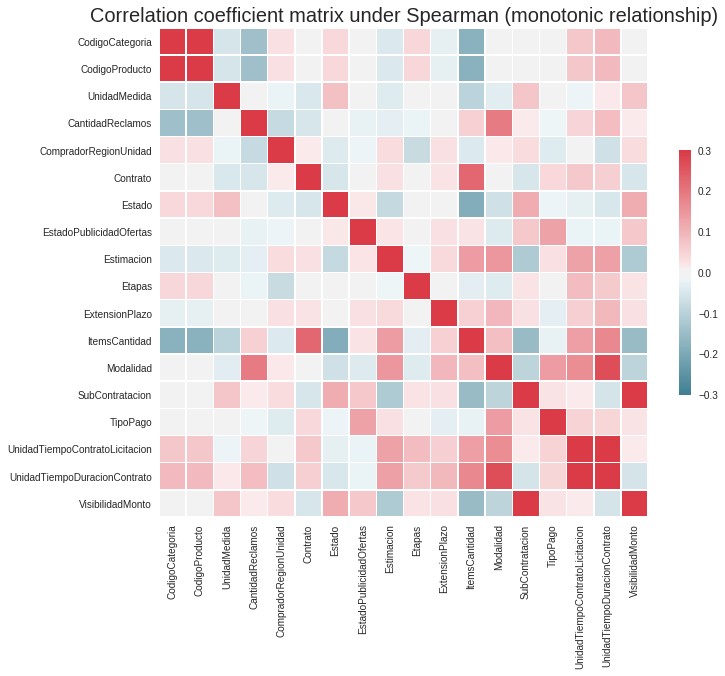

In [34]:
import seaborn as sns

corr = dataset_norm.corr('spearman')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

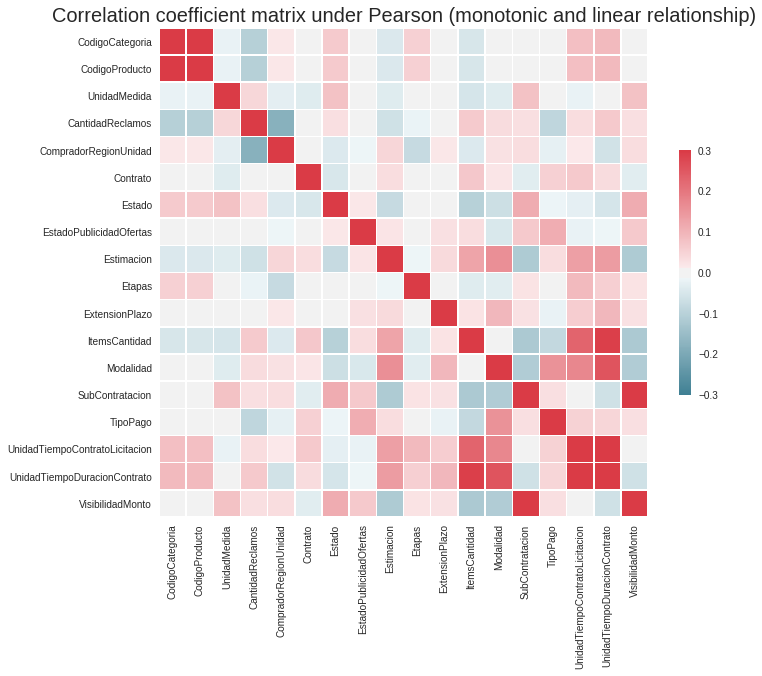

In [35]:
corr = dataset_norm.corr('pearson')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Pearson (monotonic and linear relationship)', fontsize=20)

### Removing more features

In [36]:
to_remove = ['CodigoCategoria', 'Obras', 'CodigoTipo', 'time_est_decision_days',
            'UnidadTiempoEvaluacion', 'UnidadTiempoDuracionContrato', 
            'Contrato', 'Etapas', 'ExtensionPlazo', 'Moneda']
non_remove = [col for col in dataset_norm.columns if col not in to_remove]
dataset_norm = dataset_norm[non_remove]

### Evaluate the classifiers

In [37]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

'''
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
'''
names = ["Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
#    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

'\nnames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",\n         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",\n         "Naive Bayes", "QDA"]\n'

### Distribution of target (Adjudicacion)

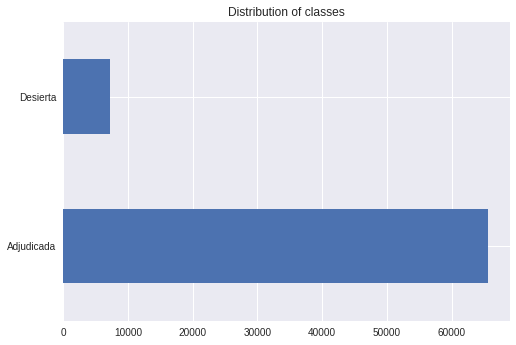

In [38]:
grouped = dataset_norm.groupby('Estado').size()
grouped.index = le_dict['Estado'].inverse_transform(grouped.index.values)
ax = grouped.plot(kind='barh')
_ = ax.set_title('Distribution of classes')

Using oversampling to achieve better balance.

### Create train and test sets

In [39]:
dataset_y = dataset_norm['Estado']
dataset_X = dataset_norm.drop('Estado', axis=1)

train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, test_size=.4, random_state=123)

# there can be overlap between train and test sets where there are instances duplicated in both train and test
# for fairer test, remove those from test
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)
before = test.shape[0]

merged = pd.merge(test, train, how='outer', indicator=True)
# select only left_only, i.e., unique test set instances
test_no_dup = merged.loc[merged._merge=='left_only']
test_no_dup.drop('_merge', inplace=True, axis=1)
after = test_no_dup.shape[0]
print('Removed {} rows from test set with original: {}'.format(before - after, before))
print('Removed {:.2f}% of original'.format((before - after) / before * 100))

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# oversample train set
grouped = train.groupby('Estado').size()
to_oversample = int(abs(grouped.diff()[1]))
print('Oversampling {} rows...'.format(to_oversample))
le = le_dict['Estado']
idx = np.random.choice(train.loc[train['Estado'] == le.transform(['Desierta'])[0]].index, size=to_oversample)
train_oversampled = pd.concat([train, train.iloc[idx]])

train_ds_list = [train, train_oversampled]
train_ds_namelist = ['Original', 'Oversampled']

test_ds_list = [test, test_no_dup]
test_ds_namelist = ['Original', 'No duplicates']


Removed 14647 rows from test set with original: 29139
Removed 50.27% of original
Oversampling 35235 rows...


In [40]:
import multiprocessing
from multiprocessing import Queue
import math
import functools as fct

In [41]:
# parallelize at the level of classifiers
def mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs):
    def worker(train_X, train_y, test_X, test_y, name_list, clf_list, out_q):
        '''
        The worker function, invoked in a process. 
        '''
        outdict = {}
        for name, clf in zip(name_list, clf_list):
            # train and test classifier
            print('Training {}...'.format(name))
            clf.fit(train_X, train_y)
            print('Testing {}...'.format(name))
            y_pred = clf.predict(test_X)
            scores = precision_recall_fscore_support(y_pred=y_pred, y_true=test_y)
            score_list = list(zip([name for _ in range(len(scores[0]))], clf.classes_,
                                 scores[0], scores[1], scores[2], scores[3]))
            # put report to dict
            outdict[name] = score_list
        # put to out_q
        out_q.put(outdict)
        
    # Each process wil get 'chunksize' clfs and a queue to put the outdict in
    out_q = Queue()
    chunksz = int(math.ceil(len(classifiers) / float(nprocs)))
    procs = []
    
    for i in range(nprocs):
        start = chunksz * i
        end = chunksz * (i + 1)
        p = multiprocessing.Process(
                target=worker,
                args=(train_X, train_y, test_X, test_y, 
                      names[start:end], classifiers[start:end], out_q))
        procs.append(p)
        p.start()
    
    # Collect all results into a single result dict
    resultdict = dict()
    for i in range(nprocs):
        outdict = out_q.get()
        resultdict.update(outdict)
    # turn resultdict to dataframe
    # print(list(resultdict.values()))
    values = fct.reduce(lambda l, x: l + x, list(resultdict.values()))
    values = list(zip(*values))
    value_dict = {'clf': values[0], 'class': values[1],
                'precision': values[2], 'recall': values[3],
                'f1': values[4], 'support': values[5]}
    result_df = pd.DataFrame(value_dict)
        
    # wait for all worker processes to finish
    for p in procs: 
        p.join()
    
    return result_df

In [42]:
le = le_dict['Estado']
target_names = le.inverse_transform([0, 1])
nprocs = multiprocessing.cpu_count()
# print(nprocs)

result_df = pd.DataFrame()
for train_ds_name, train_ds in zip(train_ds_namelist, train_ds_list):
    train_X = train_ds.drop('Estado', axis=1)
    train_y = train_ds['Estado']
    # print('Training on {} dataset'.format(train_ds_name))
    
    for test_ds_name, test_ds in zip(test_ds_namelist, test_ds_list):
        test_X = test_ds.drop('Estado', axis=1)
        test_y = test_ds['Estado']
        # los experimentos fueron realizados en otro computador, solamente importamos los resultados
        '''
        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)
        # columns about train and test set
        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]
        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]
        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]
        if result_df.empty:
            result_df = out_df
        else:
            result_df = pd.concat([result_df, out_df], axis=0)


outdir = '.' + os.sep + 'out'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
result_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)
'''

result_df = pd.read_csv('.' + os.sep + 'out' + os.sep + 'classificationResult.csv')

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

The experiments were conducted on another computer so we import the results here. Also, we had a problem with SVM (linear) and Gaussian Process.

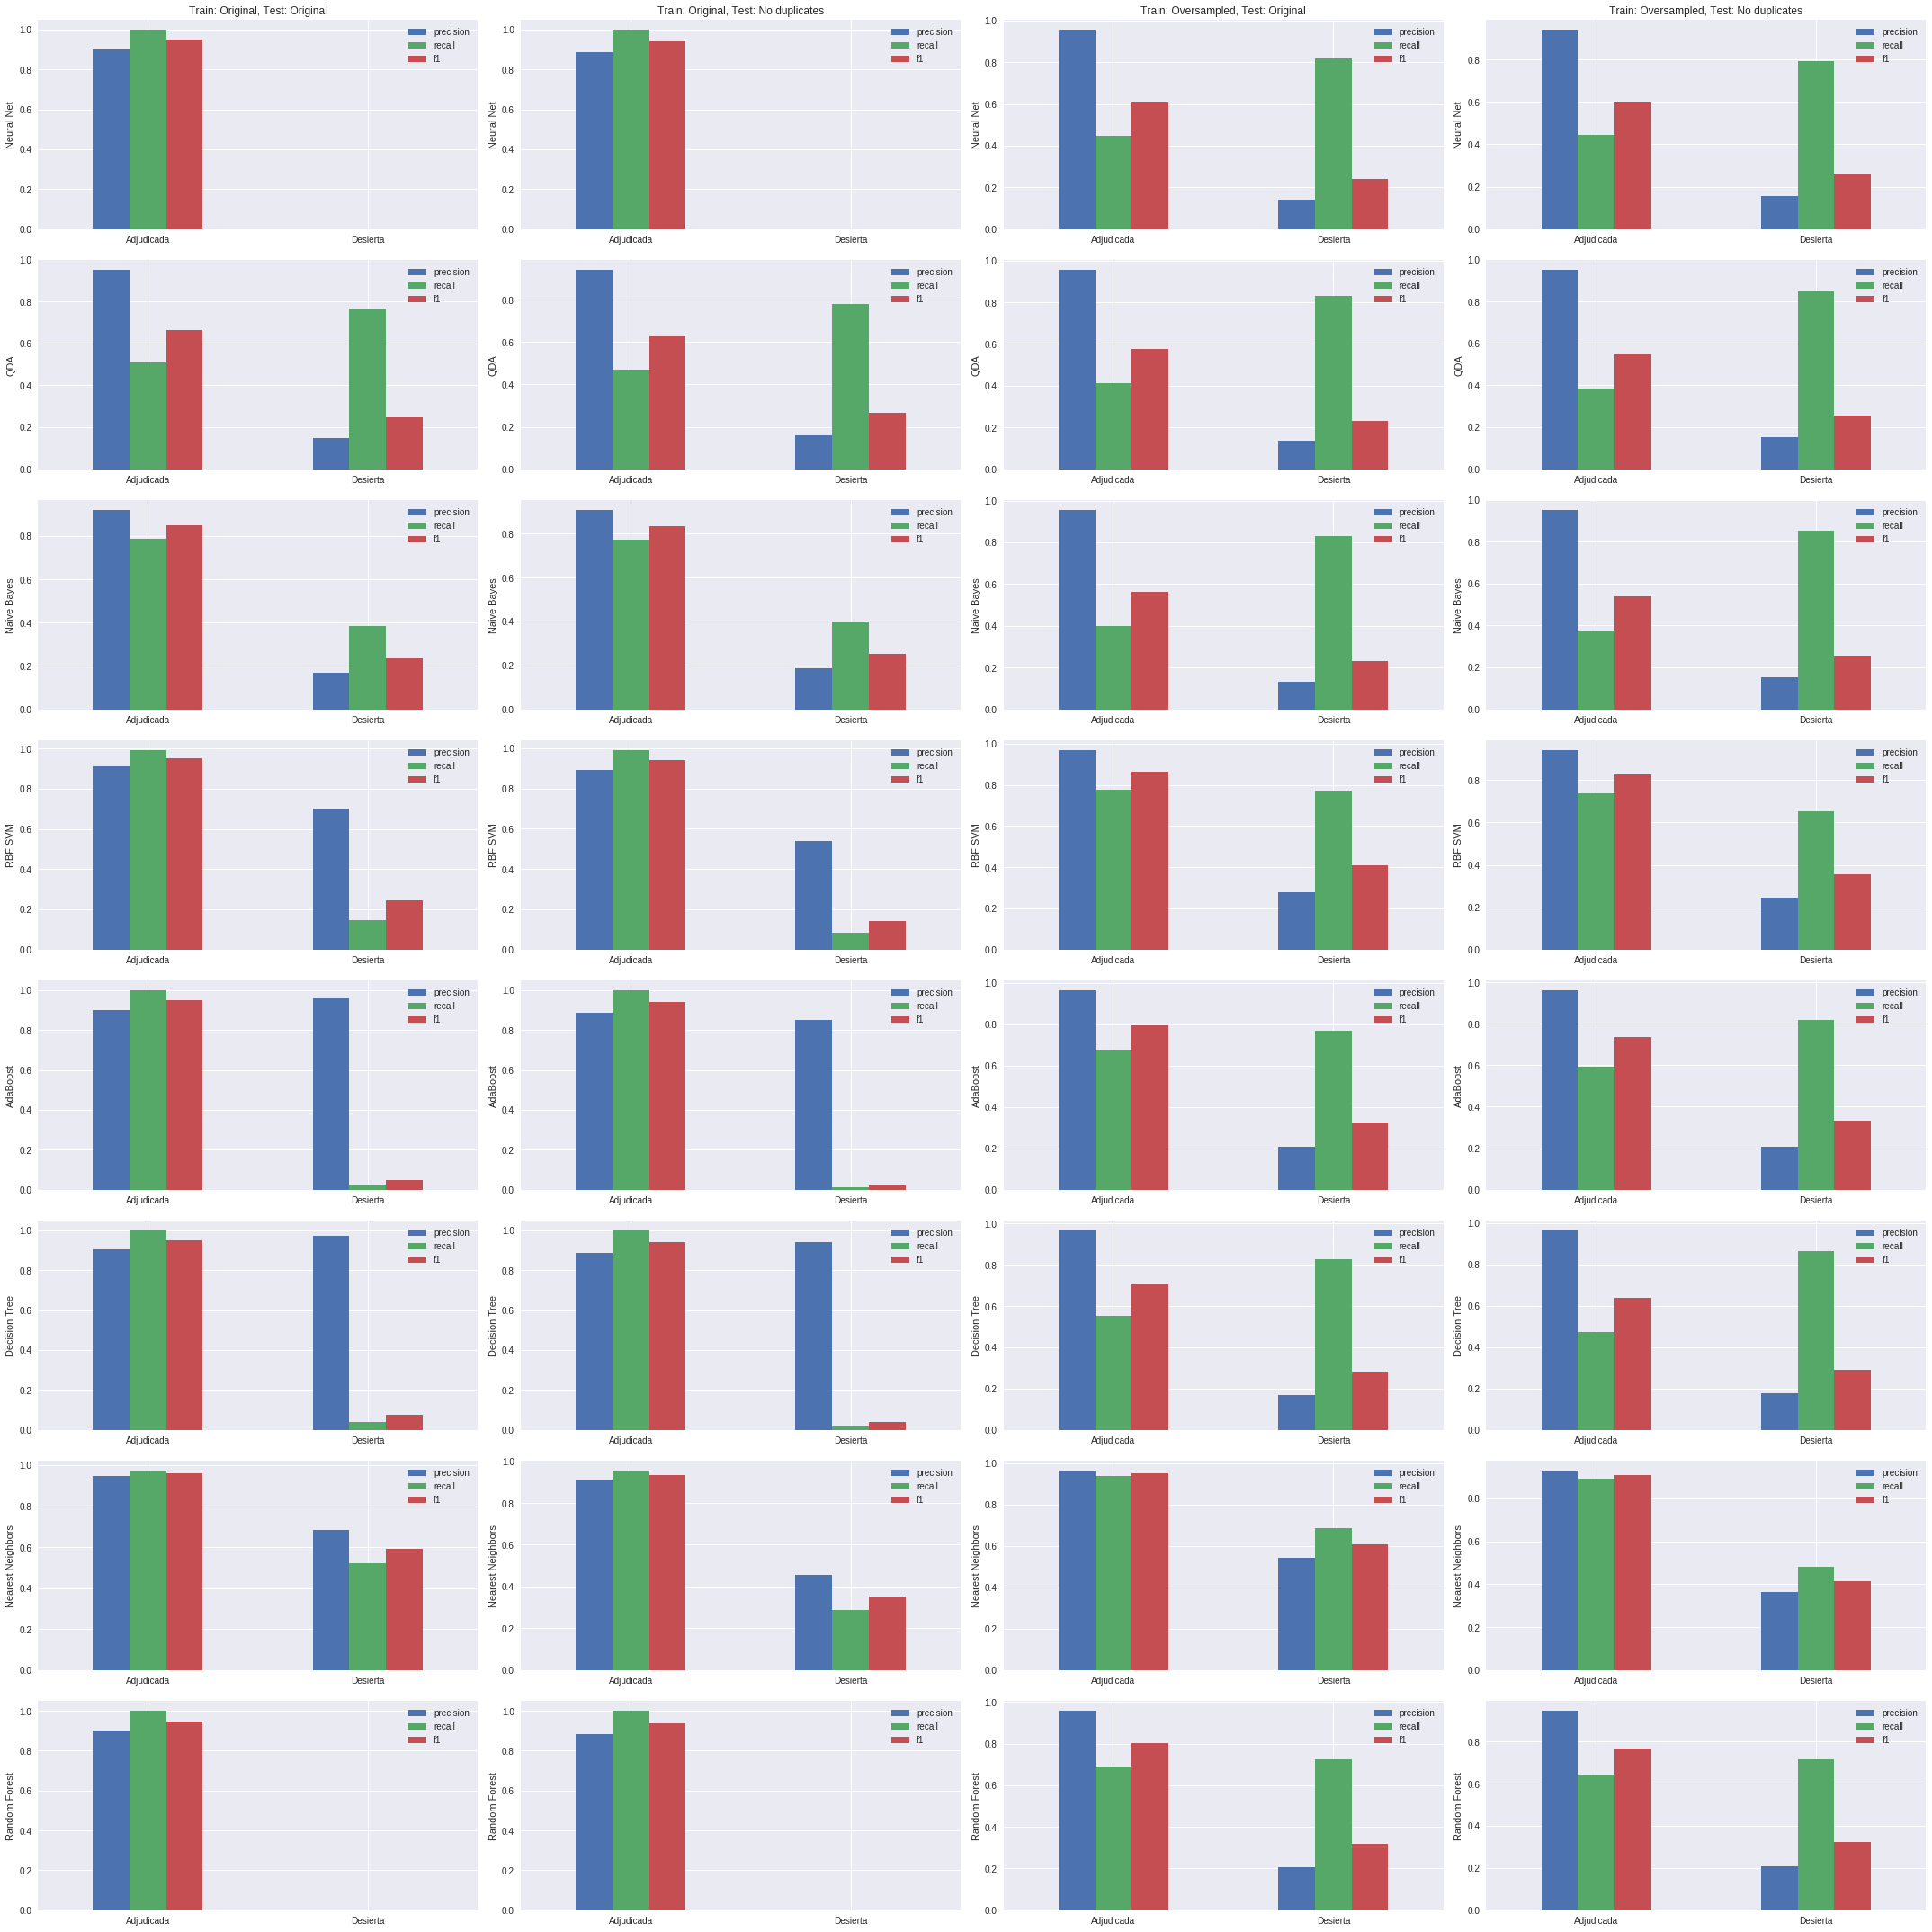

In [43]:
nrows = result_df.clf.unique().shape[0]
ncols = result_df[['train', 'test']].drop_duplicates().shape[0]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

clfs = result_df.clf.unique()
train_test_pairs = result_df[['train', 'test']].drop_duplicates().values
state_le = le_dict['Estado']

for i in range(nrows):
    clf = clfs[i]
    clf_results = result_df[(result_df.clf == clf)]
    for j in range(ncols):
        train_test_pair = train_test_pairs[j]
        # print(train_test_pair)
        ax = axes[i, j]
        result = clf_results[(clf_results['train']==train_test_pair[0])&
                            (clf_results['test']==train_test_pair[1])]
        # print(result)
        _ = result[['precision', 'recall', 'f1']].plot(kind='bar', ax=ax, rot=0);
        
        if i == 0:
            _ = ax.set_title('Train: {}, Test: {}'.format(train_test_pair[0], train_test_pair[1]))
        _ = ax.set_ylabel('{}'.format(clf))
        _ = ax.set_xticklabels(state_le.inverse_transform(result['class']))
        
# plt.savefig('./classificationResult.png')
plt.tight_layout()

# Classify tender traces
### Tender sale as quality criteria
~20% of the tenders are deserted for various reasons, e.g., no offers. This means ~3000 tenders and ~7000 tender products are not sold. However, what happens to the deserted tenders? Investigation shows that public organizations actually can republish the same tender. As such, $\textit{tender traces}$ can occur where each item of the tender trace is an individual tender. Some trace actually ends with a tender that is sold. 
For example: (example where tender trace ends with a sold tender, explain that the company who bid could not have been created in 18 days)

### Research questions
- What characteristics do traces that end with sold state?

### Experiment design
- Classification to classify these different types of traces
- Clustering

### Preprocessing
1. Remove columns with >90% null values or 0 variance
2. Remove tenders with 1 tender product
3. Get deserted tenders
4. Do not consider tenders related to hospital and health because of granularity issues, many times there are such big variances in product of the same product code that make it difficult to differentiate one tender product from other without looking into the contract.
5. For all the deserted tenders, find similar tenders by the tender name and organization.
6. Filter tender traces by validating the tender products and tender publication and close dates

In [67]:
# get the dfs from 2016
tender_df_list = list()
tprod_df_list = list()

for f in os.listdir('./data/processed2016/'):
    if 'tsmall' in f:
        tender_df_list.append(f)
    else:
        tprod_df_list.append(f)
        
tender_df_list = sorted(tender_df_list)
tprod_df_list = sorted(tprod_df_list)

print(tender_df_list)
print(tprod_df_list)

tender_df_list = [pd.read_csv(os.path.join('./data/processed2016/', df)) for df in tender_df_list]
tprod_df_list = [pd.read_csv(os.path.join('./data/processed2016/', df)) for df in tprod_df_list]

['tsmall01.csv', 'tsmall02.csv', 'tsmall03.csv', 'tsmall04.csv', 'tsmall05.csv', 'tsmall06.csv', 'tsmall07.csv', 'tsmall08.csv', 'tsmall09.csv', 'tsmall10.csv', 'tsmall11.csv', 'tsmall12.csv']
['tsprod01.csv', 'tsprod02.csv', 'tsprod03.csv', 'tsprod04.csv', 'tsprod05.csv', 'tsprod06.csv', 'tsprod07.csv', 'tsprod08.csv', 'tsprod09.csv', 'tsprod10.csv', 'tsprod11.csv', 'tsprod12.csv']


In [68]:
for df in tender_df_list:
    df.FechasFechaPublicacion = pd.to_datetime(df.FechasFechaPublicacion)
    df.sort_values('FechasFechaPublicacion', ascending=True, inplace=True)

## Getting the deserted tender traces of length > 1
### Get deserted tenders

In [69]:
def get_deserted(tender_df):
    tdesert_df = tender_df[
        (tender_df['Estado'].str.lower().str.startswith('desier'))
    ]
    return tdesert_df

desert_df_list = list()
for tender_df in tender_df_list:
    desert_df = get_deserted(tender_df)
    desert_df_list.append(desert_df)

### Getting the tender traces as described previously

In [70]:
def get_small_desert(tdesert_df):
    # the following organizations have low quality description in their tenders, basically they use the same tender name 
    # for the majority of their tenders
    excl_org_code = [7326, 87901]
    # some examples that did not make sense and therefore excluded
    excl_tid = ['3928-78-L116', '3928-82-L116', '3477-236-L116', '3477-241-L116',
               '2409-878-L116', '2409-910-L116']

    deserted = tdesert_df[
        ~(tdesert_df['CompradorCodigoOrganismo'].isin(excl_org_code))&
        ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.startswith('hospital'))&
        ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.contains('salud'))&
        ~(tdesert_df['CodigoExterno'].isin(excl_tid))
    ][['CodigoExterno', 'Nombre', 'FechasFechaPublicacion', 'FechasFechaCierre', 'CompradorCodigoOrganismo']].sort_values('FechasFechaPublicacion')
    return deserted

def get_similar_tenders(tender_df, deserted):
    similar_df = pd.DataFrame()
    checked = list()
    for td in deserted.itertuples():
        # check if this tender has been checked already
        if [td.CompradorCodigoOrganismo, td.Nombre] in checked:
            continue
        checked.append([td.CompradorCodigoOrganismo, td.Nombre])
        # identify similar tenders
        similar = tender_df[
            (tender_df['CompradorCodigoOrganismo']==td.CompradorCodigoOrganismo)&
            (tender_df['Nombre']==td.Nombre)
        ].sort_values('FechasFechaPublicacion')[['Estado', 'FechasFechaPublicacion', 'FechasFechaCierre', 'Nombre',
                                                 'CompradorNombreOrganismo', 'CompradorCodigoOrganismo', 'AdjudicacionUrlActa', 'CodigoExterno']]
        if similar_df.empty:
            similar_df = similar
        else:
            similar_df = pd.concat([similar_df, similar], axis=0)  
    return similar_df

deserted_small_df_list = list()
for df in desert_df_list:
    deserted = get_small_desert(df)
    deserted_small_df_list.append(deserted)
    
similar_df_list = list()
for tender_df, deserted_df in zip(tender_df_list, deserted_small_df_list):
    similar_df = get_similar_tenders(tender_df, deserted_df)
    similar_df_list.append(similar_df)

### Consider only traces with length > 1 and ensure validity

In [71]:
def get_trace_rows(similar_df):
    trace_spec = similar_df.groupby('Nombre').size()
#     print('Total deserted: {}\nTotal traces > 1: {}'.format(trace_spec[trace_spec == 1].shape, 
#                                                             trace_spec[trace_spec > 1].shape))
    trace_spec = trace_spec[trace_spec > 1].index.values
    trace_row_df = similar_df[(similar_df['Nombre'].isin(trace_spec))]
    return trace_row_df

trace_row_df_list = list()
for similar_df in similar_df_list:
    trace_row_df = get_trace_rows(similar_df)
    trace_row_df_list.append(trace_row_df)

In [72]:
def valid_dates(group, tids):
    # check dates
    last = None
    for tid in tids:
        if last is None:
            last = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
        else:
            # check date
            now = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
            if pd.to_datetime(now[0]) < pd.to_datetime(last[1]):
                # the publication date is smaller than the close date of the last tender
                return False
            last = now
    return True

def valid_tprods(tprod_df, tids):
    prod_dict = dict()
    for tid in tids:
        tprods = tprod_df[(tprod_df['CodigoExterno']==tid)]['CodigoProducto'].values
        tprods.sort()
        prod_dict[tid] = tprods
    # zip them
    for item_tuple in zip(*list(prod_dict.values())):
        if len(set(item_tuple)) > 1:
            return False
    return True

In [73]:
def filter_trace_row(trace_row_df, tprod_df):
    non_comply = list()
    for name, group in trace_row_df.groupby('Nombre'):
        tids = group['CodigoExterno'].values
        # check dates
        if not valid_dates(group, tids):
            non_comply.append(tids)
            continue
        # check products
        if not valid_tprods(tprod_df, tids):
            non_comply.append(tids)
            continue
    if len(non_comply) > 0:
        non_comply = fcts.reduce(lambda x, y: np.concatenate((x, y)), non_comply)
        trace_row_df = trace_row_df[~(trace_row_df['CodigoExterno'].isin(non_comply))]
    return trace_row_df

aux = list()
for df, tprod_df in zip(trace_row_df_list, tprod_df_list):
    trace_row_df = filter_trace_row(df, tprod_df)
    aux.append(trace_row_df)
    
trace_row_df_list = aux

### Distribution across regions

22/362 has trace length > 1
24/381 has trace length > 1
18/386 has trace length > 1
39/538 has trace length > 1
36/488 has trace length > 1
44/507 has trace length > 1
26/411 has trace length > 1
31/485 has trace length > 1
17/417 has trace length > 1
21/420 has trace length > 1
33/474 has trace length > 1
17/319 has trace length > 1


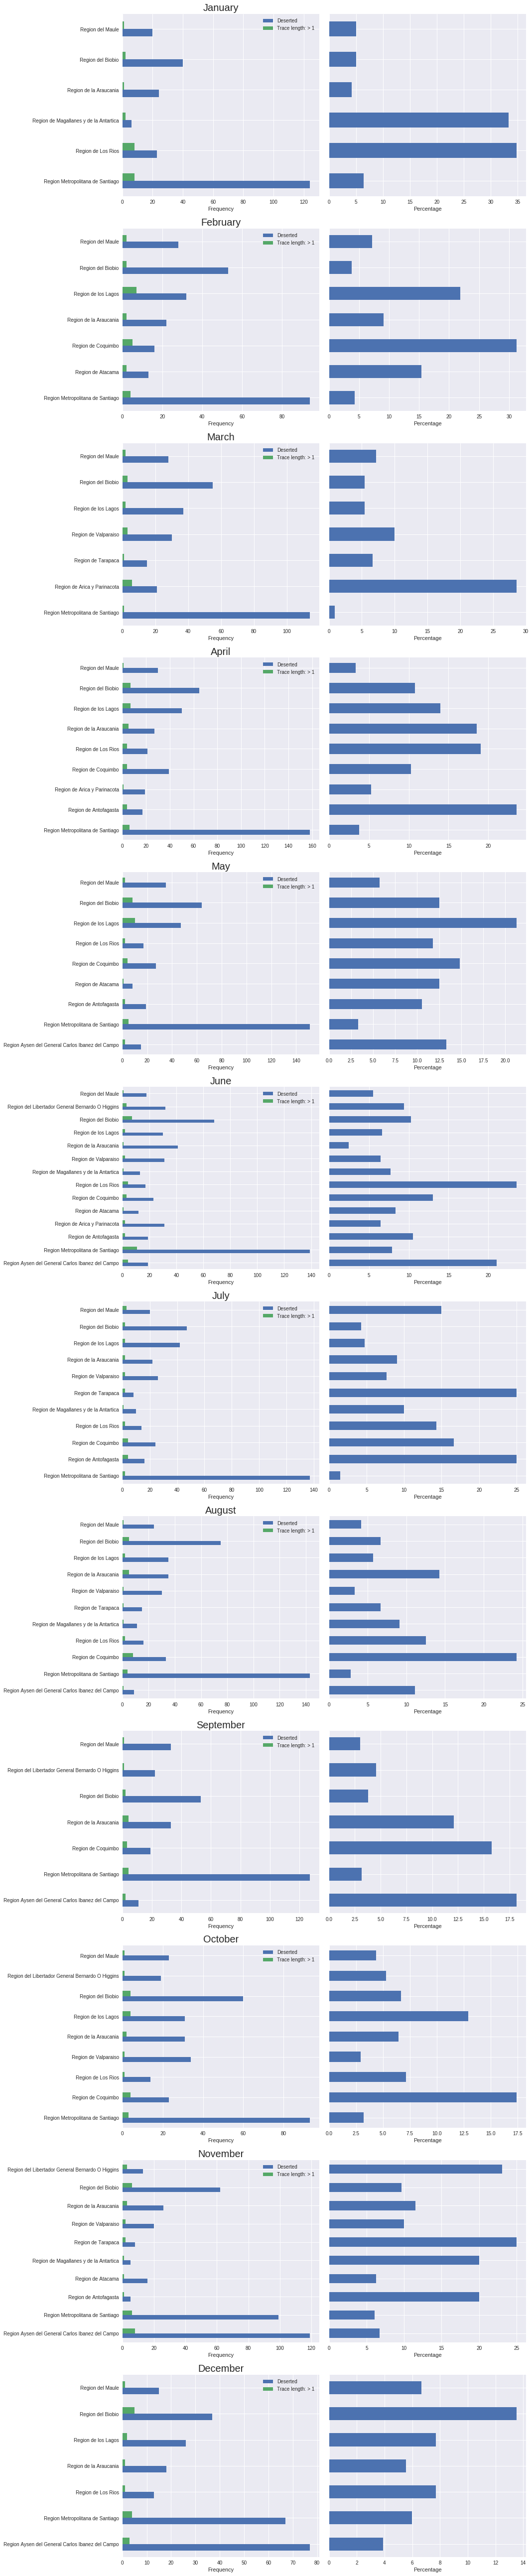

In [74]:
import calendar

def plot_trace_dist(tender_df, deserted, trace_row_df, rowid, axes):
    grouped_before = tender_df[(tender_df['CodigoExterno'].isin(deserted['CodigoExterno'].values))].groupby('CompradorRegionUnidad').size()
    grouped_after = tender_df[(tender_df['CodigoExterno'].isin(trace_row_df['CodigoExterno']))&
                             (tender_df['Estado'].str.lower().str.startswith('desi'))].groupby('CompradorRegionUnidad').size()
    
    print('{}/{} has trace length > 1'.format(grouped_after.sum(), grouped_before.sum()))
    
    grouped_before = grouped_before.to_frame().reset_index()
    grouped_after = grouped_after.to_frame().reset_index()
    grouped = grouped_before.merge(grouped_after, on='CompradorRegionUnidad')
    grouped.columns = ['CompradorRegionUnidad', 'Deserted', 'Trace length: > 1']
    grouped['perc'] = grouped['Trace length: > 1'] / grouped['Deserted'] * 100
    grouped.sort_values('CompradorRegionUnidad', inplace=True, ascending=True)

    grouped[['CompradorRegionUnidad', 'Deserted', 'Trace length: > 1']].plot(kind='barh', ax=axes[rowid, 0]);
    axes[rowid, 0].set_yticklabels(grouped['CompradorRegionUnidad'])
    axes[rowid, 0].set_xlabel('Frequency')
    axes[rowid, 0].set_title('{}'.format(calendar.month_name[rowid+1]), fontsize=20);

    grouped[['CompradorRegionUnidad', 'perc']].plot(kind='barh', ax=axes[rowid, 1], legend=None);
    axes[rowid, 1].set_yticklabels([]);
    axes[rowid, 1].set_xlabel('Percentage');

rowid_list = range(12)
fig, axes = plt.subplots(figsize=(15, 6 * 12), ncols=2, nrows=12)
for tender_df, deserted, trace_row_df, rowid in zip(tender_df_list, deserted_small_df_list, 
                                                    trace_row_df_list, rowid_list):
    plot_trace_dist(tender_df, deserted, trace_row_df, rowid, axes)

plt.tight_layout();

In [75]:
avg_revival_rate = list()
month = 1
for trace_row_df in trace_row_df_list:
    grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: 'Adjudicada' in x['Estado'].values)
    revival_rate = (grouped_state.sum() / grouped_state.shape[0])
    print('Revival rate ({:02d}): {:.2f}% ({}/{})'.format(month, revival_rate, grouped_state.sum(), grouped_state.shape[0]))
    month += 1
    avg_revival_rate.append((revival_rate, grouped_state.shape[0]))

total_sale = fcts.reduce(lambda x, y: x + y[1], avg_revival_rate, 0)
avg_revival_rate = fcts.reduce(lambda x, y: x + y[0] * (y[1] / total_sale), avg_revival_rate, 0)
print('Weighted avg revival rate: {:.2f}'.format(avg_revival_rate))

Revival rate (01): 0.60% (9/15)
Revival rate (02): 0.74% (14/19)
Revival rate (03): 0.88% (14/16)
Revival rate (04): 0.77% (24/31)
Revival rate (05): 0.58% (15/26)
Revival rate (06): 0.60% (18/30)
Revival rate (07): 0.76% (16/21)
Revival rate (08): 0.75% (18/24)
Revival rate (09): 0.71% (10/14)
Revival rate (10): 0.60% (9/15)
Revival rate (11): 0.55% (12/22)
Revival rate (12): 0.79% (11/14)
Weighted avg revival rate: 0.69


### Distribution in terms of product category

In [76]:
grouped_cat = tprod_df[
    (tprod_df['CodigoExterno'].isin(trace_row_df['CodigoExterno'].values))
].groupby('Categoria').size().to_frame().reset_index()

grouped_cat.columns = ['Categoria', 'count']
grouped_cat.sort_values('count', inplace=True, ascending=False)
grouped_cat.reset_index(drop=True, inplace=True)

grouped_cat.head()

,Categoria,count
0,Instrumentos musicales juegos juguetes artesanias y materiales educativos / Juguetes y juegos / Juguetes,36
1,Articulos de fabricacion y produccion / Articulos de ferreteria / Tornillos,20
2,Servicios de transporte almacenaje y correo / Transporte de pasajeros / Transporte de pasajeros por carretera,14
3,Equipos y suministros de defensa orden publico proteccion y seguridad / Proteccion contra incendios / Equipos para combatir incendios,12
4,Articulos de fabricacion y produccion / Articulos de ferreteria / Espaciadores,12


## Divide to two classes

In [77]:
def merge_df(trace_row_df):
    grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: int('Adjudicada' in x['Estado'].values))
    grouped_state = grouped_state.to_frame().reset_index()
    grouped_state.columns = ['Nombre', 'class_sold']

    merged = trace_row_df.merge(grouped_state, on='Nombre')
    merged[(merged['class_sold']==0)]

    return merged

merged_df_list = list()
for trace_row_df in trace_row_df_list:
    merged = merge_df(trace_row_df)
    merged_df_list.append(merged)

### Revived case
An example where a tender gets revived in a re-publication.

In [78]:
merged_all_df = pd.concat(merged_df_list, axis=0)

merged_all_df[
    (merged_all_df['CodigoExterno'].isin(['2401-442-L116', '2401-467-L116']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
4,Desierta o art 3 o 9 Ley 19 886,2016-11-02 15:33:25.950,2016-11-08T12:01:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=t27FwHY6GxhIEjFmTlRD6yyYduI7UlEBWC6N4Q0ABXo=,2401-442-L116,1
5,Adjudicada,2016-11-15 17:04:11.183,2016-11-22T12:00:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=ckCgGyh5kukvjtTq6rUOy23XxwBsgCyz3x7T4cedS3k=,2401-467-L116,1


### Remains dead
An example where a tender remains deserted in the future re-publication.

In [79]:
merged_all_df[
    (merged_all_df['CodigoExterno'].isin(['1989-99-L116', '1989-104-CO16']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
2,Desierta o art 3 o 9 Ley 19 886,2016-11-02 15:23:50.373,2016-11-10T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=HJfcGaPNPX9fLUtNwNIuJVnzatvdmhHFwZl9efRvz+U=,1989-99-L116,0
3,Desierta o art 3 o 9 Ley 19 886,2016-11-23 16:37:08.103,2016-12-01T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=Qn8nkbm19kyaC/lMqhdo9XBRJBMJ0G6q2k62Rth9e/I=,1989-104-CO16,0


## Constructing trace df with features

In [80]:
def compute_lapse(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    lapse_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            lapse_list.append(now.FechasFechaPublicacion - last.FechasFechaCierre)
        last = now
    return np.mean(lapse_list)

def compute_duration(tname, df):
    return df.loc[(df['Nombre']==tname), 'tender_duration'].mean()

def cmp_desc_chg(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    change_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            change_list.append(now.desc_len - last.desc_len)
        last = now
    return np.mean(change_list)

def cmp_trace_len(tname, df):
    return df[(df['Nombre']==tname)].shape[0]

In [81]:
tall_df_list = list()

for tender_df, tprod_df in zip(tender_df_list, tprod_df_list):
    tall_df = tprod_df.merge(tender_df, on='CodigoExterno')
    tall_df_list.append(tall_df)

In [82]:
def compute_tender_duration(df):
    df['FechasFechaPublicacion'] = pd.to_datetime(df.loc[:,'FechasFechaPublicacion'])
    df['FechasFechaCierre'] = pd.to_datetime(df.loc[:,'FechasFechaCierre'])
    df['tender_duration'] = df['FechasFechaCierre'] - df['FechasFechaPublicacion']

In [83]:
def get_avg_df(tall_df):
    # product code, region, average number of words in description, item quantity, reclamos, 
    aux = tall_df[['CodigoProducto', 'CompradorRegionUnidad', 'Descripcion_x', 
                   'ItemsCantidad', 'CantidadReclamos', 'CodigoExterno']]
    aux['desc_len'] = aux['Descripcion_x'].astype(str).apply(lambda x: len(x))
    aux['desc_len'] = aux['desc_len'].fillna(0)
#    print(aux['desc_len'].unique())
    frame = aux.groupby('CodigoExterno').agg({'desc_len': 'mean'})
    frame = frame.reset_index()
    aux = aux.drop('desc_len', axis=1)
    aux = aux.merge(frame, on='CodigoExterno')
    aux.drop_duplicates('CodigoExterno', inplace=True)
    return aux

tall_avg_df_list = list()
for tall_df in tall_df_list:
    tall_avg_df = get_avg_df(tall_df)
    tall_avg_df_list.append(tall_avg_df)

In [84]:
def get_trace_df(merged, tall_avg_df):
    trace_df = merged[['Nombre', 'class_sold', 'CompradorCodigoOrganismo', 'CodigoExterno',
                      'FechasFechaPublicacion', 'FechasFechaCierre']]
    compute_tender_duration(trace_df)
    trace_df.loc[:,'lapse'] = trace_df.loc[:,'Nombre'].apply(lambda x: compute_lapse(x, trace_df))
    trace_df['avg_tduration'] = trace_df.loc[:,'Nombre'].apply(lambda x: compute_duration(x, trace_df))
    
    # trace_df = trace_df.merge(merged[['Nombre', 'CodigoExterno']], on='Nombre')
    trace_df = trace_df.merge(tall_avg_df, on='CodigoExterno')
    trace_df['name_len'] = trace_df['Nombre'].apply(len) 
    trace_df['avg_desc_chg'] = trace_df['Nombre'].apply(lambda x: cmp_desc_chg(x, trace_df))
    trace_df['trace_len'] = trace_df['Nombre'].apply(lambda x: cmp_trace_len(x, trace_df))
    trace_df = trace_df[[colname for colname in trace_df.columns if colname != 'CodigoExterno']]
    trace_df = trace_df[[colname for colname in trace_df.columns 
                         if not (colname == 'Descripcion_x' or colname == 'CodigoExterno' 
                                 or colname == 'Nombre' or colname == 'FechasFechaPublicacion' 
                                or colname == 'FechasFechaCierre' or colname == 'tender_duration' 
                                or colname == 'CodigoProducto') ]]
    # convert timedelta columns to hours
    trace_df['lapse'] = trace_df['lapse'].dt.components.hours
    trace_df['avg_tduration'] = trace_df['avg_tduration'].dt.components.hours
    
    return trace_df

trace_df_list = list()
for merged_df, tall_avg_df in zip(merged_df_list, tall_avg_df_list):
    trace_df = get_trace_df(merged_df, tall_avg_df)
    trace_df_list.append(trace_df)

In [85]:
trace_df = pd.concat(trace_df_list, axis=0)

### Convert to numerical

In [86]:
from sklearn import preprocessing

# make the following columns to string so that they can be mapped to lower values for training
trace_df['CompradorCodigoOrganismo'] = trace_df['CompradorCodigoOrganismo'].astype(str)
# trace_df['CodigoProducto'] = trace_df['CodigoProducto'].astype(str)

le_dict = dict()
for col in trace_df.columns:
    if np.issubdtype(trace_df[col].dtype, np.number):
        continue
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(trace_df[col])
    # transform the labels
    trace_df[col] = le.transform(trace_df[col])
    # save the labeler
    le_dict[col] = le

### Quitar columnas con baja varianza

In [87]:
var_threshold = .01
for col in trace_df.columns:
    if trace_df[col].var() < var_threshold:
        print('Removing column: {}'.format(col))
        trace_df.drop(col, axis=1, inplace=True)

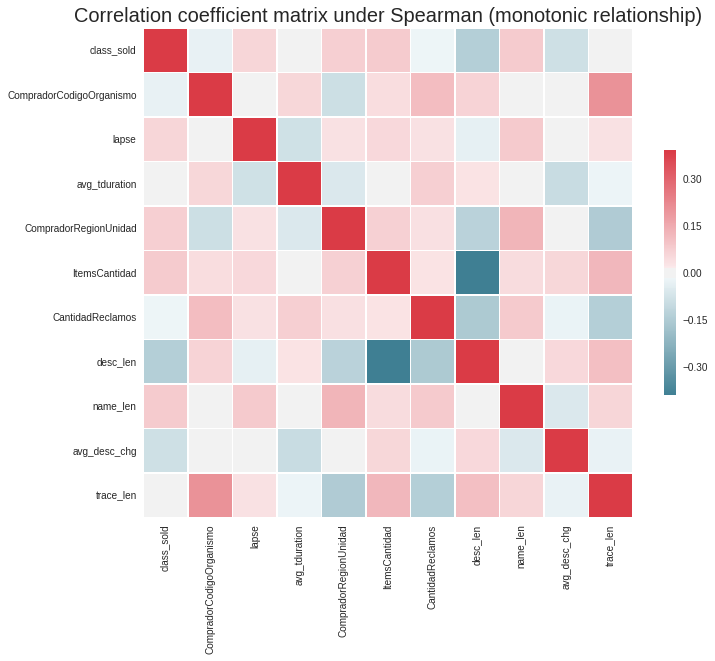

In [88]:
import seaborn as sns

corr = trace_df.corr('spearman')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
               square=True, linewidth=.5, cbar_kws={'shrink': .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

## Classification with class_sold

In [89]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.dummy import DummyClassifier

'''
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
'''
names = ["Dummy (Stratified)", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    DummyClassifier(strategy='stratified', random_state=0, constant=0),
    KNeighborsClassifier(3),
#    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

'\nnames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",\n         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",\n         "Naive Bayes", "QDA"]\n'

### Distribution of the objective class

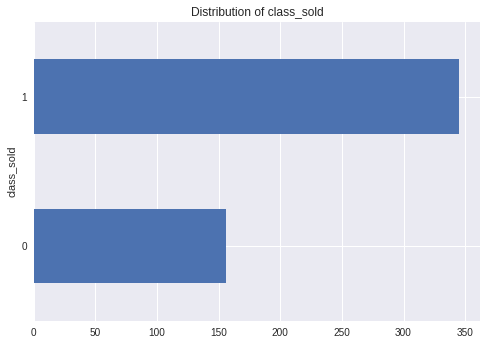

In [90]:
grouped = trace_df.groupby('class_sold').size()
ax = grouped.plot(kind='barh')
ax.set_title('Distribution of class_sold');

### Create train and test sets

In [91]:
dataset_y = trace_df['class_sold']
dataset_X = trace_df.drop('class_sold', axis=1)

train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, test_size=.4, random_state=123)

# there can be overlap between train and test sets where there are instances duplicated in both train and test
# for fairer test, remove those from test
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)
before = test.shape[0]

merged = pd.merge(test, train, how='outer', indicator=True)
# select only left_only, i.e., unique test set instances
test_no_dup = merged.loc[merged._merge=='left_only']
test_no_dup.drop('_merge', inplace=True, axis=1)
after = test_no_dup.shape[0]
print('Removed {} rows from test set with original: {}'.format(before - after, before))
print('Removed {:.2f}% of original'.format((before - after) / before * 100))

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# oversample train set
grouped = train.groupby('class_sold').size()
to_oversample = int(abs(grouped.diff()[1]))
print('Oversampling {} rows...'.format(to_oversample))
idx = np.random.choice(train.loc[train['class_sold'] == 0].index, size=to_oversample)
train_oversampled = pd.concat([train, train.iloc[idx]])

train_ds_list = [train, train_oversampled]
train_ds_namelist = ['Original', 'Oversampled']

test_ds_list = [test, test_no_dup]
test_ds_namelist = ['Original', 'No duplicates']

Removed 92 rows from test set with original: 201
Removed 45.77% of original
Oversampling 98 rows...


In [92]:
import multiprocessing
from multiprocessing import Queue
import math

In [93]:
# parallelize at the level of classifiers
def mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs):
    def worker(train_X, train_y, test_X, test_y, name_list, clf_list, out_q):
        '''
        The worker function, invoked in a process. 
        '''
        outdict = {}
        for name, clf in zip(name_list, clf_list):
            # train and test classifier
            # print('Training {}...'.format(name))
            clf.fit(train_X, train_y)
            # print('Testing {}...'.format(name))
            y_pred = clf.predict(test_X)
#            report = classification_report(y_pred=y_pred, y_true=test_y)
            scores = precision_recall_fscore_support(y_pred=y_pred, y_true=test_y)
            score_list = list(zip([name for _ in range(len(scores[0]))], clf.classes_,
                                 scores[0], scores[1], scores[2], scores[3]))
            # put report to dict
            outdict[name] = score_list
        # put to out_q
        out_q.put(outdict)
        
    # Each process wil get 'chunksize' clfs and a queue to put the outdict in
    out_q = Queue()
    chunksz = int(math.ceil(len(classifiers) / float(nprocs)))
    procs = []
    
    for i in range(nprocs):
        start = chunksz * i
        end = chunksz * (i + 1)
        p = multiprocessing.Process(
                target=worker,
                args=(train_X, train_y, test_X, test_y, 
                      names[start:end], classifiers[start:end], out_q))
        procs.append(p)
        p.start()
    
    # Collect all results into a single result dict
    resultdict = dict()
    for i in range(nprocs):
        outdict = out_q.get()
        resultdict.update(outdict)
    # turn resultdict to dataframe
    # print(list(resultdict.values()))
    values = fcts.reduce(lambda l, x: l + x, list(resultdict.values()))
    values = list(zip(*values))
    value_dict = {'clf': values[0], 'class': values[1],
                'precision': values[2], 'recall': values[3],
                'f1': values[4], 'support': values[5]}
    result_df = pd.DataFrame(value_dict)
        
    # wait for all worker processes to finish
    for p in procs: 
        p.join()
    
    return result_df

In [94]:
nprocs = multiprocessing.cpu_count()
# print(nprocs)

result_df = pd.DataFrame()
for train_ds_name, train_ds in zip(train_ds_namelist, train_ds_list):
    train_X = train_ds.drop('class_sold', axis=1)
    train_y = train_ds['class_sold']
    # print('Training on {} dataset'.format(train_ds_name))
    
    for test_ds_name, test_ds in zip(test_ds_namelist, test_ds_list):
        test_X = test_ds.drop('class_sold', axis=1)
        test_y = test_ds['class_sold']
        # los experimentos fueron realizados en otro computador, solamente importamos los resultados
        
        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)
        # columns about train and test set
        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]
        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]
        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]
        if result_df.empty:
            result_df = out_df
        else:
            result_df = pd.concat([result_df, out_df], axis=0)

'''
outdir = '.' + os.sep + 'out'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
result_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)
'''

# result_df = pd.read_csv('.' + os.sep + 'out' + os.sep + 'classificationResult.csv');

"\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

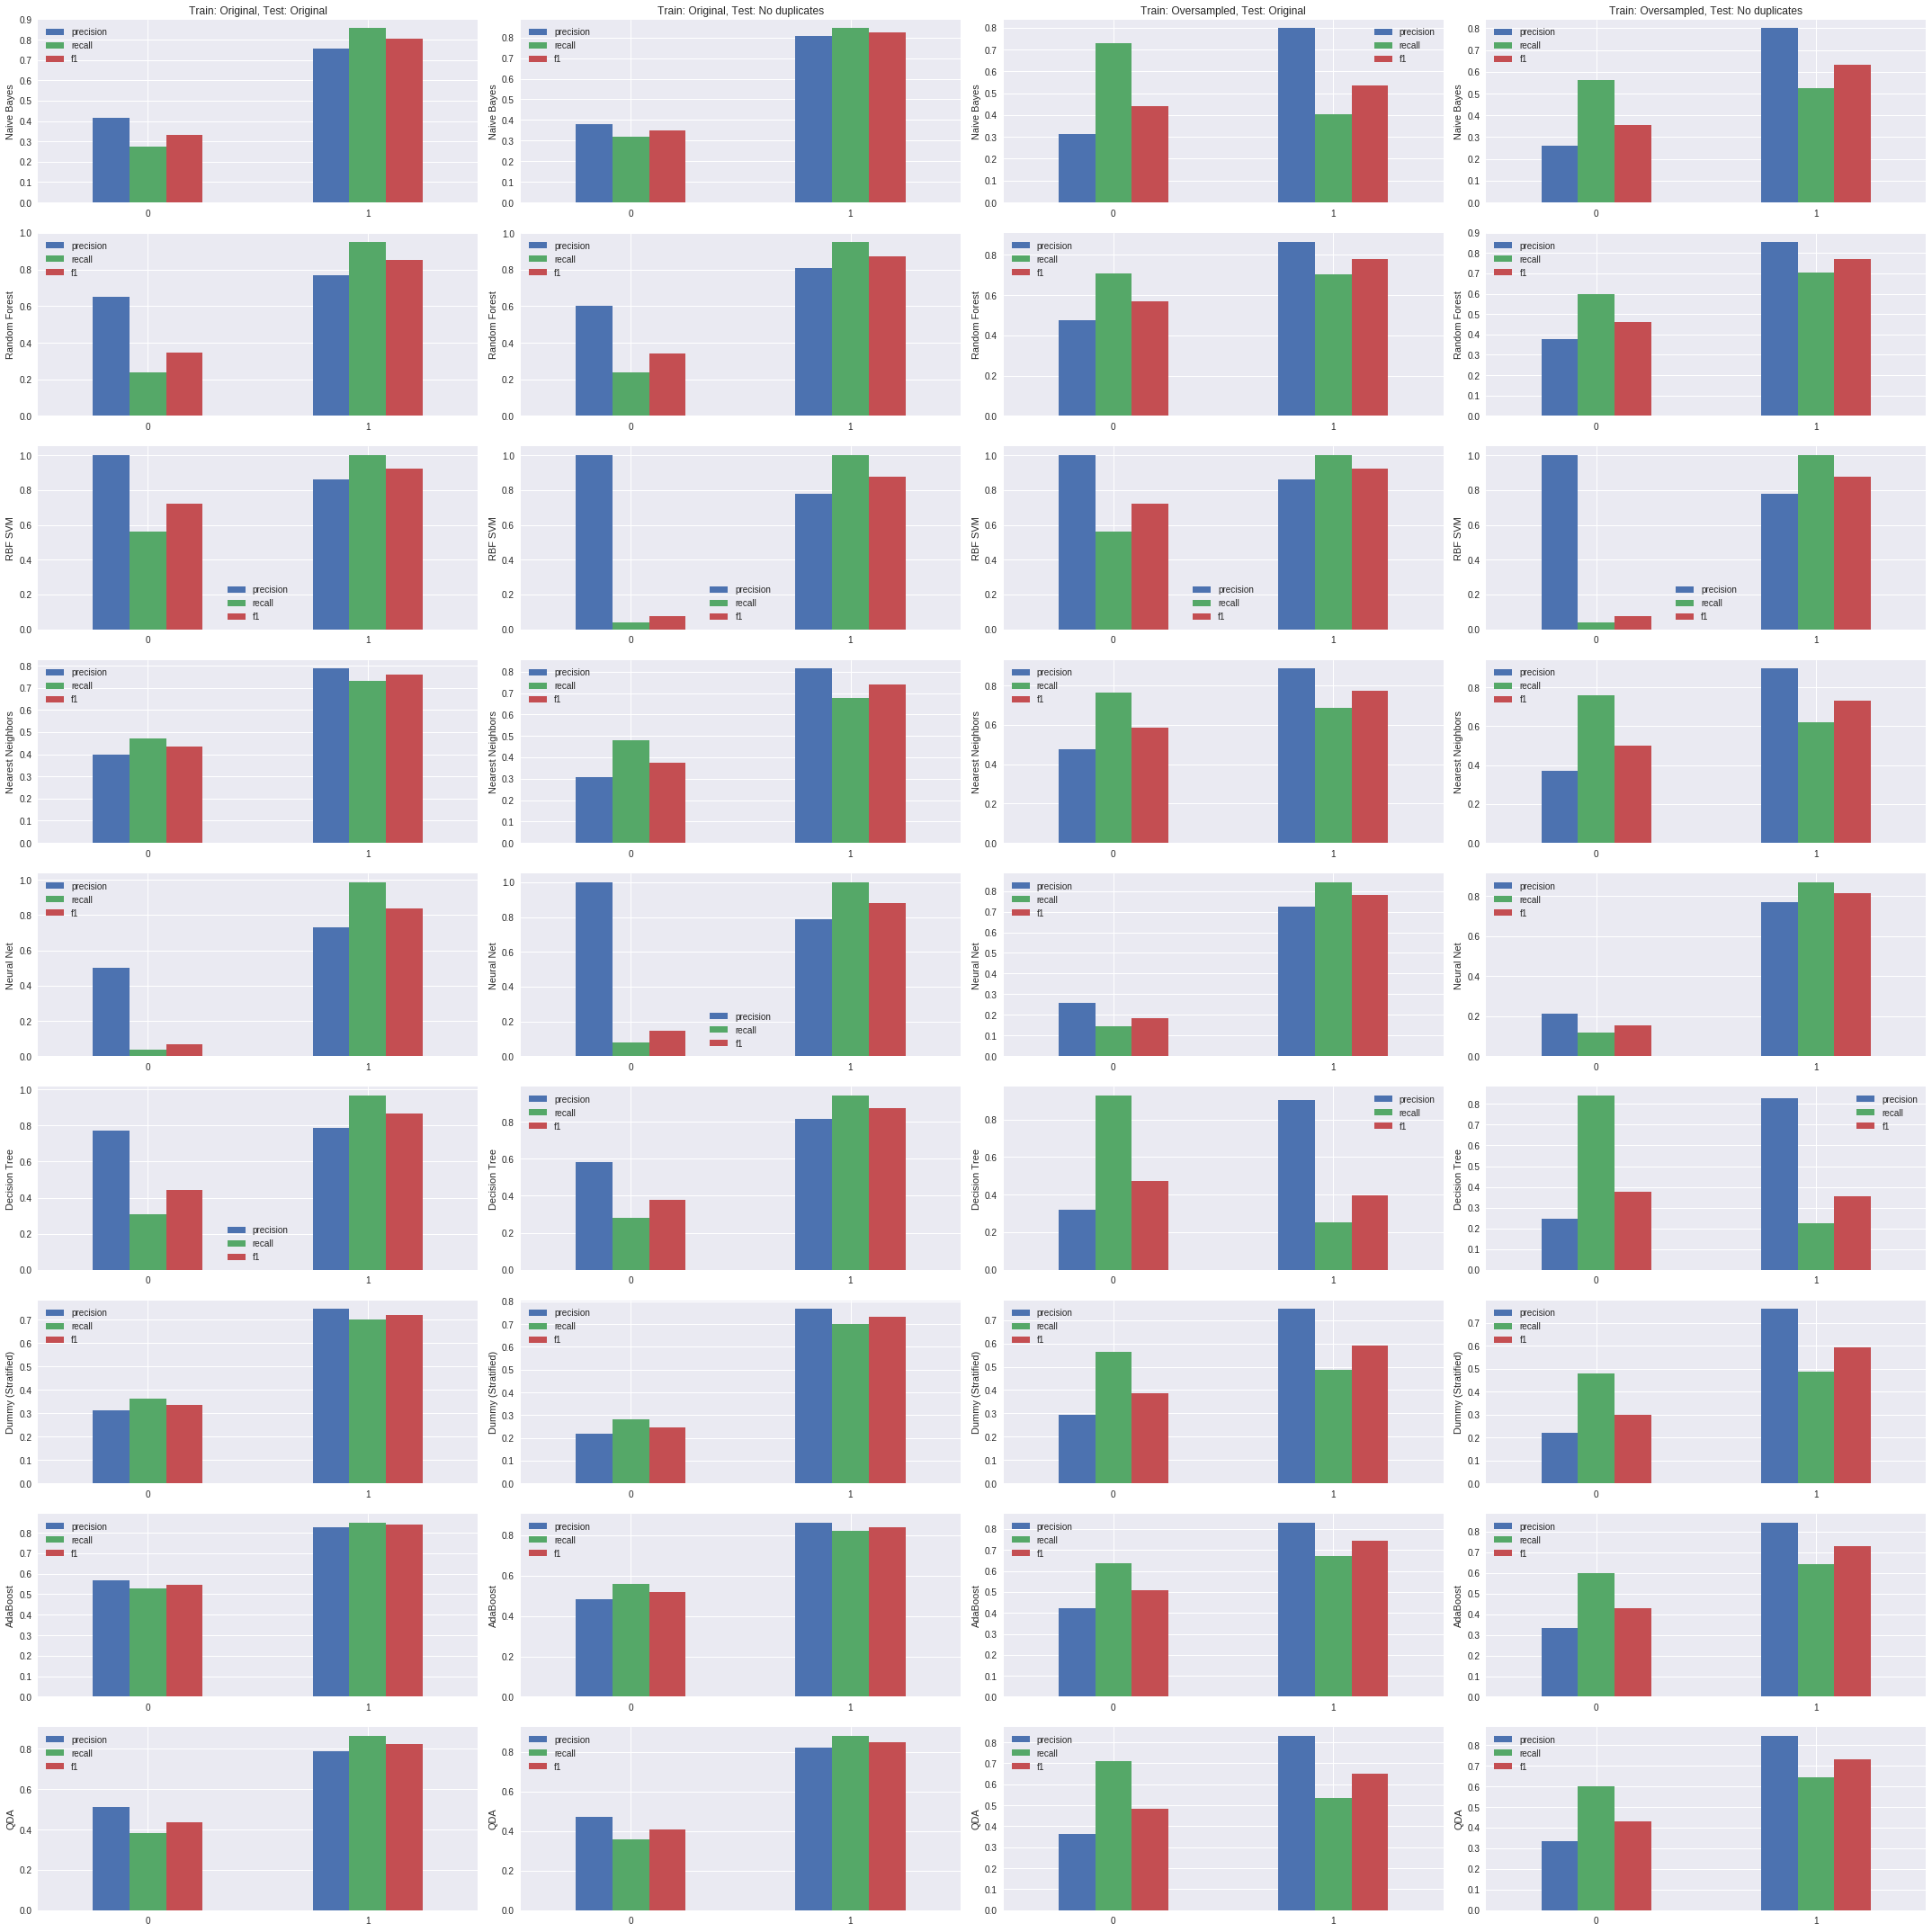

In [95]:
nrows = result_df.clf.unique().shape[0]
ncols = result_df[['train', 'test']].drop_duplicates().shape[0]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

clfs = result_df.clf.unique()
train_test_pairs = result_df[['train', 'test']].drop_duplicates().values

for i in range(nrows):
    clf = clfs[i]
    clf_results = result_df[(result_df.clf == clf)]
    for j in range(ncols):
        train_test_pair = train_test_pairs[j]
        # print(train_test_pair)
        ax = axes[i, j]
        result = clf_results[(clf_results['train']==train_test_pair[0])&
                            (clf_results['test']==train_test_pair[1])]
        # print(result)
        _ = result[['precision', 'recall', 'f1']].plot(kind='bar', ax=ax, rot=0);
        
        if i == 0:
            _ = ax.set_title('Train: {}, Test: {}'.format(train_test_pair[0], train_test_pair[1]))
        _ = ax.set_ylabel('{}'.format(clf))
        _ = ax.set_xticklabels(result['class'])
        
# plt.savefig('./classificationResult.png')
plt.tight_layout()

In [96]:
# test with original train and no duplicates for test
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

for name, clf in zip(names, classifiers):
    if name not in ["Dummy (Stratified)", "Nearest Neighbors", 
         "Decision Tree", "Random Forest", "AdaBoost"]:
        continue
    _ = clf.fit(train_X, train_y);
    y_pred = clf.predict(test_X);
    report = classification_report(y_pred=y_pred, y_true=test_y);
    print('{}'.format(name))
    print(report);
    print();

Dummy (Stratified)
             precision    recall  f1-score   support

          0       0.22      0.28      0.25        25
          1       0.77      0.70      0.73        84

avg / total       0.64      0.61      0.62       109


Nearest Neighbors
             precision    recall  f1-score   support

          0       0.31      0.48      0.38        25
          1       0.81      0.68      0.74        84

avg / total       0.70      0.63      0.66       109


Decision Tree
             precision    recall  f1-score   support

          0       0.58      0.28      0.38        25
          1       0.81      0.94      0.87        84

avg / total       0.76      0.79      0.76       109


Random Forest
             precision    recall  f1-score   support

          0       0.50      0.24      0.32        25
          1       0.80      0.93      0.86        84

avg / total       0.73      0.77      0.74       109


AdaBoost
             precision    recall  f1-score   support

        

In [97]:
# get the original, no duplicates pair
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

ds_X = pd.concat([train_X, test_X], axis=0)
ds_y = pd.concat([train_y, test_y], axis=0)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(ds_X, ds_y)

In [98]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(clf, out_file='tree.dot',
                               feature_names=train_X.columns,
                               class_names=['Deserted', 'Sold'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)


### Analysis of decision tree
![tree](./out/tree.png)

We can see that the feature works but we also have a little bit of overfitting.

## Clustering
In this experiment, we use clustering to see if there's any clusters of the tender trace features.

In [99]:
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import kneighbors_graph
import warnings, time
from itertools import cycle, islice


### Scale to [0, 1]

In [100]:
# remove the class_sold
cluster_ds = trace_df.drop('class_sold', axis=1)
min_max_scaler = MinMaxScaler()
cluster_ds_scaled = min_max_scaler.fit_transform(cluster_ds)
# cluster_ds_scaled = StandardScaler().fit_transform(cluster_ds)
cluster_ds_scaled = pd.DataFrame(cluster_ds_scaled)
cluster_ds_scaled.columns = cluster_ds.columns

### Elbow test to find optimal number of clusters

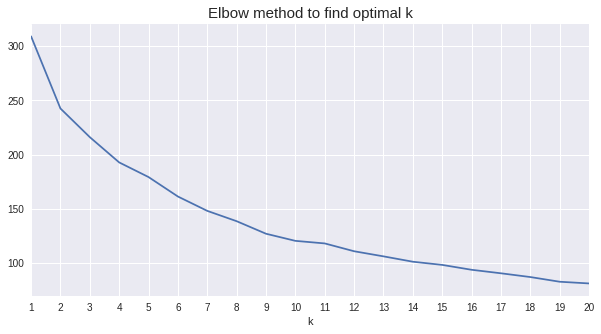

In [101]:
# test until 20 k
maxK = 20
sse_list = np.zeros(maxK)
# number of different initial centroids
n_init = 20
n_jobs = -1
for i in range(maxK):
    k = i + 1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=k, n_jobs=n_jobs).fit(cluster_ds_scaled)
    # get the sse from kmeans
    sse_list[i] = kmeans.inertia_
    
sse_zip = list(zip(*enumerate(sse_list)))
sse_dict = {'k': sse_zip[0],
           'sse': sse_zip[1]}
sse_df = pd.DataFrame(sse_dict)
sse_df.k = sse_df.k.apply(lambda x: x + 1)

sse_df.set_index(sse_df.k, inplace=True)
ax = sse_df.sse.plot(xticks=sse_df.index, figsize=(10, 5))
_ = ax.set_title('Elbow method to find optimal k', fontsize=15)

In [102]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Explained variance ratio (first two components): [ 0.2425216  0.1961849]


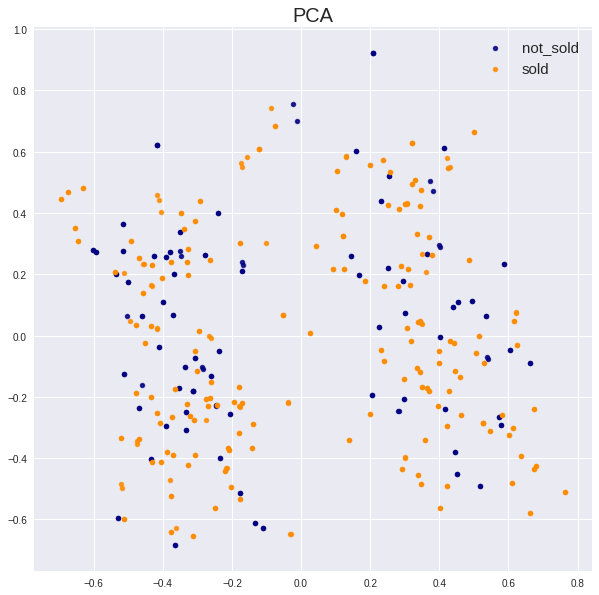

In [103]:
y = trace_df['class_sold']
target_names = ['not_sold', 'sold']
pca = PCA(n_components=2)
X_r = pca.fit(cluster_ds_scaled).transform(cluster_ds_scaled)

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): {}'.format(str(pca.explained_variance_ratio_)))

fig, ax = plt.subplots(figsize=(10, 10))
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=.8, lw=lw,
               label=target_name, s=12)
ax.legend(loc='best', shadow=False, scatterpoints=1, fontsize=15)
ax.set_title('PCA', fontsize=20);

fig.savefig('./out/pca.png');

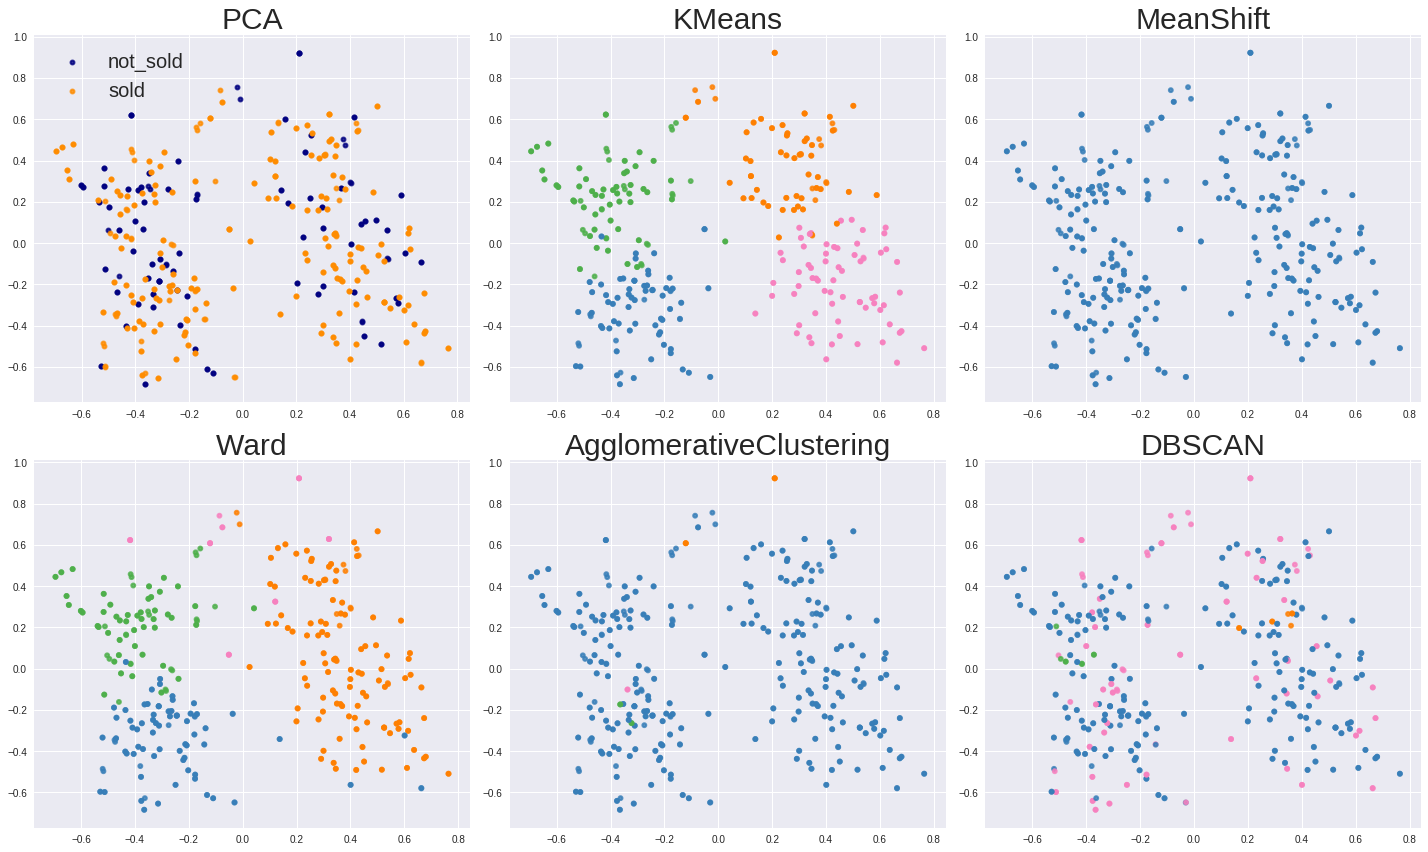

In [104]:
params = {'quantile': .6,
               'eps': .4,
               'damping': .9,
               'preference': -200,
               'n_neighbors': 10, 
               'n_clusters': 4}

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(cluster_ds_scaled.values, quantile=params['quantile'])

# connectivity matrix for structured ward
connectivity = kneighbors_graph(cluster_ds_scaled, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create the cluster objects
kmeans = cluster.KMeans(n_clusters=params['n_clusters'], n_jobs=-1)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity
)
dbscan = cluster.DBSCAN(eps=params['eps'])
average_linkage = cluster.AgglomerativeClustering(
    linkage='average', affinity='cityblock', 
    n_clusters=params['n_clusters'], connectivity=connectivity)

clustering_algorithms = (
    ('KMeans', kmeans),
#    ('MiniBatchMeans', two_means),
    ('MeanShift', ms),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan)
)

s = 15
cnt = 1
nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(20, 12), nrows=nrows, ncols=ncols)
true_y = trace_df['class_sold']
target_names = ['not_sold', 'sold']
pca = PCA(n_components=2)
X_r = pca.fit(cluster_ds_scaled).transform(cluster_ds_scaled)

colors = ['navy', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    axes[0, 0].scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=.8, lw=lw,
               label=target_name, s=s)
axes[0, 0].legend(loc='best', shadow=False, scatterpoints=1, fontsize=20)
axes[0, 0].set_title('PCA', fontsize=30);

for name, algorithm in clustering_algorithms:
    t0 = time.time()
    
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(cluster_ds_scaled)
    
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(cluster_ds_scaled)
    
    row = cnt // ncols
    col = cnt % ncols
    cnt += 1
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
    axes[row, col].scatter(X_r[:, 0], X_r[:, 1], color=colors[y_pred], alpha=.8, lw=lw, s=s)
    axes[row, col].set_title('{}'.format(name), fontsize=30);

plt.tight_layout();

# Referencias

- [1] https://www.mercadopublico.cl/Home/Contenidos/QueEsMercadoPublico
- [2] https://www.mercadopublico.cl/Home/Contenidos/QueEsLicitacion
- [3] https://www.mercadopublico.cl/Home/Contenidos/QueEsCM
- [4] https://www.mercadopublico.cl/Home/Contenidos/QueEsOC
- [5] Hilbert, M. (2016). Big Data for Development: A Review of Promises and Challenges. Development Policy Review, 34(1), 135–174. http://doi.org/10.1111/dpr.12142 
- [6] J. Ben Schafer (1999), Recommender Systems in E-Commerce, University of Minnesota.
- [7] Patrick McCole (2005), A profile of adopters and non adopters of e-commerce in SMPE Professional Service Firms. 
- [8] Francisca Silva, Nicolas Majluf, Ricardo D. Paredes Pontificia Universidad Católica de Chile, Santiago, Chile 2005 Family Ties, Interlocking Directors and Performance of Business Groups in Emerging Countries: The Case of Chile.
- [9] Cláudio Weber Abramo, Eduardo Ribeiro Capobianco - Tender offer and public offers in Brasil.
- [10] http://www.chilecompra.cl/2017/08/ahorros-a-traves-de-chilecompra-superaron-los-188-mil-millones-el-2017/